# Predictive HR Analytics - Employee Attrition

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

**Bringing in Market data to include compa ratio in the dataset which is an important metric in HR. Compa ratio is arrived by dividing employee salary by the market median.**

In [2]:
market = pd.read_csv("MarketData.csv")

In [3]:
market.head()

,Role,Level,Role & Level,Experience Range (Years),Incumbent Average Compensation (USD),Incumbent Median Compensation (USD),Market Salary Range (USD),Market Median (USD),Compa Ratio
0,Healthcare Representative,2,Healthcare Representative 2,4–10,"$70,384","$68,856","65,000–85,000","$75,000",92%
1,Healthcare Representative,3,Healthcare Representative 3,9–15,"$112,367","$118,248","100,000–130,000","$115,000",103%
2,Healthcare Representative,4,Healthcare Representative 4,10–25,"$155,676","$162,036","140,000–180,000","$160,000",101%
3,Human Resources,1,Human Resources 1,0–6,"$32,799","$32,352","50,000–65,000","$55,000",59%
4,Human Resources,2,Human Resources 2,4–10,"$66,762","$71,820","60,000–80,000","$70,000",103%


**Bringing in Master Attrition Data set from IBM**

In [4]:
df = pd.read_csv('EmployeeAttrition.csv')

In [5]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


**Creating JobRoleLevel from JobRole and JobLevel; this column will be used to lookup market median from market data.**

In [6]:
df['JobRoleLevel'] = df['JobRole'] + ' ' + df['JobLevel'].astype(str)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobRoleLevel
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,Sales Executive 2
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,Research Scientist 2
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,Laboratory Technician 1
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,Research Scientist 1
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,Laboratory Technician 1


**Merge the relevant column in Attrition Data based on matching role-level  as available in Market data**

In [7]:
df = df.merge(
    market[['Role & Level', 'Market Median (USD)']],
    left_on='JobRoleLevel',
    right_on='Role & Level',
    how='left'
)

# New Features

**Calculating Compa Ratio by dividing annual salary (MonthlyIncome × 12) by Market Median (USD); used to assess how an employee's pay compares to the market.**

In [8]:
# Compa Ratio
df['Market Median (USD)'] = df['Market Median (USD)'].replace('[\$,]', '', regex=True).astype(float)
df['Compa Ratio'] = (df['MonthlyIncome'] * 12) / df['Market Median (USD)']
df[['MonthlyIncome', 'Market Median (USD)', 'Compa Ratio']].head()

,MonthlyIncome,Market Median (USD),Compa Ratio
0,5993,75000.0,0.958880
1,5130,65000.0,0.947077
2,2090,48000.0,0.522500
3,2909,52000.0,0.671308
4,3468,48000.0,0.867000


**Creating PromotionStagnation as the ratio of YearsSinceLastPromotion to YearsAtCompany; indicates delay or lack of career progression.**

This measure highlights employees who may feel stuck in their roles due to a lack of upward mobility.

In [9]:
df['PromotionStagnation'] = df.apply(
    lambda x: x['YearsSinceLastPromotion'] / x['YearsAtCompany'] if x['YearsAtCompany'] != 0 else 0,
    axis=1
)


**Creating RoleTenureRatio as the ratio of YearsInCurrentRole to YearsAtCompany; reflects stability or movement within the company.**

A lower ratio may indicate active movement or growth within the organization, while a high ratio could signal stagnation or lack of opportunity

In [10]:
df['RoleTenureRatio'] = df.apply(
    lambda x: x['YearsInCurrentRole'] / x['YearsAtCompany'] if x['YearsAtCompany'] != 0 else 0,
    axis=1
)


**Creating JobHoppingCategory based on JobHoppingIndex, which is calculated as (NumCompaniesWorked + 1) / TotalWorkingYears. This feature captures external mobility or job-switching tendency and is categorized for better interpretability and modeling performance.**

Fresher: No prior work experience.

Stable: Few job changes; long tenures.

Moderate: Occasional job changes; balanced career path.

Frequent: Many job changes; short stints common.

Chronic: Very frequent moves; possible instability.

In [11]:
# Step 1: Create JobHoppingIndex
df['JobHoppingIndex'] = df.apply(
    lambda x: (x['NumCompaniesWorked'] + 1) / x['TotalWorkingYears'] if x['TotalWorkingYears'] != 0 else 0,
    axis=1
)

# Step 2: Categorize based on NumCompaniesWorked and JobHoppingIndex
def categorize_job_hopping(row):
    if pd.isna(row['NumCompaniesWorked']) or pd.isna(row['JobHoppingIndex']):
        return np.nan
    elif row['NumCompaniesWorked'] == 0:
        return 'Fresher'
    elif row['JobHoppingIndex'] <= 0.2:
        return 'Stable'
    elif row['JobHoppingIndex'] <= 0.5:
        return 'Moderate'
    elif row['JobHoppingIndex'] <= 1:
        return 'Frequent'
    else:
        return 'Chronic'

# Step 3: Apply the function row-wise to create the category
df['JobHoppingCategory'] = df.apply(categorize_job_hopping, axis=1)

# Step 4: Convert to object type (unordered categorical)
df['JobHoppingCategory'] = df['JobHoppingCategory'].astype(str)

# Step 5: Drop the original numeric feature
df.drop(columns=['JobHoppingIndex'], inplace=True)


**Creating PromotionFlag based on whether YearsSinceLastPromotion equals YearsAtCompany; flags if the employee never had a promotion (No Promotion) or had at least one (Had Promotion).**

In [12]:
df['PromotionFlag'] = df.apply(
    lambda x: 'No Promotion' if x['YearsSinceLastPromotion'] == x['YearsAtCompany'] else 'Had Promotion',
    axis=1
)


**Checking the Final Data set before EDA**

In [13]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,YearsSinceLastPromotion,YearsWithCurrManager,JobRoleLevel,Role & Level,Market Median (USD),Compa Ratio,PromotionStagnation,RoleTenureRatio,JobHoppingCategory,PromotionFlag
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,0,5,Sales Executive 2,Sales Executive 2,75000.0,0.958880,0.000,0.666667,Chronic,Had Promotion
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,1,7,Research Scientist 2,Research Scientist 2,65000.0,0.947077,0.100,0.700000,Stable,Had Promotion
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,0,Laboratory Technician 1,Laboratory Technician 1,48000.0,0.522500,0.000,0.000000,Frequent,No Promotion
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,0,Research Scientist 1,Research Scientist 1,52000.0,0.671308,0.375,0.875000,Moderate,Had Promotion
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,2,2,Laboratory Technician 1,Laboratory Technician 1,48000.0,0.867000,1.000,1.000000,Chronic,No Promotion


**Drop clearly redundant or low-utility columns**

In [14]:
columns_to_drop = [
    'EmployeeNumber',       # Unique identifier; not useful for modeling
    'EmployeeCount',        # Constant value (always 1); adds no predictive power
    'Over18',               # Constant ("Y" for all rows); provides no variation
    'StandardHours',        # Constant (80 for all); does not contribute to modeling
    'Market Median (USD)',  # Used only to derive `Compa Ratio`; no longer needed after feature creation
    'Role & Level',         # Used only to lookup `Compa Ratio`; no longer needed after feature creation
    'JobRoleLevel'          # Used only to lookup `Compa Ratio`; no longer needed after feature creation
]

In [15]:
# Drop the columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

# Show remaining columns for verification
df.columns.tolist()

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Compa Ratio',
 'PromotionStagnation',
 'RoleTenureRatio',
 'JobHoppingCategory',
 'PromotionFlag']

# Exploratory Data Analysis (EDA)

**Step 1: Data Structure Overview**

In [16]:
# Shape of the dataset
print("Dataset Shape (rows, columns):", df.shape)
# List of all column names
print("\nColumn Names:")
print(df.columns.tolist())

Dataset Shape (rows, columns): (1470, 36)

Column Names:
['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Compa Ratio', 'PromotionStagnation', 'RoleTenureRatio', 'JobHoppingCategory', 'PromotionFlag']


In [17]:
# Stored data types
print("\nStored Data Types:")
print(df.dtypes)


Stored Data Types:
Age                           int64
Attrition                    object
BusinessTravel               object
DailyRate                     int64
Department                   object
DistanceFromHome              int64
Education                     int64
EducationField               object
EnvironmentSatisfaction       int64
Gender                       object
HourlyRate                    int64
JobInvolvement                int64
JobLevel                      int64
JobRole                      object
JobSatisfaction               int64
MaritalStatus                object
MonthlyIncome                 int64
MonthlyRate                   int64
NumCompaniesWorked            int64
OverTime                     object
PercentSalaryHike             int64
PerformanceRating             int64
RelationshipSatisfaction      int64
StockOptionLevel              int64
TotalWorkingYears             int64
TrainingTimesLastYear         int64
WorkLifeBalance               int64
YearsAtC

**Appropriate data type mapping of Ordinal Variables**

In [18]:
# Convert ordinal and discrete count variables to categorical dtype
ordinal_cols = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobSatisfaction',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'PerformanceRating',
    'WorkLifeBalance',
    'JobLevel'
]

df[ordinal_cols] = df[ordinal_cols].astype('category')


In [19]:
# Rechecking Stored data types
print("\nStored Data Types:")
print(df.dtypes)


Stored Data Types:
Age                            int64
Attrition                     object
BusinessTravel                object
DailyRate                      int64
Department                    object
DistanceFromHome               int64
Education                   category
EducationField                object
EnvironmentSatisfaction     category
Gender                        object
HourlyRate                     int64
JobInvolvement              category
JobLevel                    category
JobRole                       object
JobSatisfaction             category
MaritalStatus                 object
MonthlyIncome                  int64
MonthlyRate                    int64
NumCompaniesWorked             int64
OverTime                      object
PercentSalaryHike              int64
PerformanceRating           category
RelationshipSatisfaction    category
StockOptionLevel            category
TotalWorkingYears              int64
TrainingTimesLastYear          int64
WorkLifeBalance   

**This version of the dataset retains all original and engineered features, including ordinal and discrete variables (e.g., Education, JobSatisfaction, StockOptionLevel), for use in tree-based models like Decision Tree, Random Forest, and XGBoost. These models can handle categorical and ordinal variables without explicit encoding or scaling.**

In [20]:
# Tree models can use all variables as-is (including ordinal as numeric)
df_Trees = df.copy()

**Data Summary**

In [21]:
# Summary of numerical columns
print("\nSummary of Numerical Columns:")
print(df.describe())



Summary of Numerical Columns:
               Age    DailyRate  DistanceFromHome   HourlyRate  MonthlyIncome  \
count  1470.000000  1470.000000       1470.000000  1470.000000    1470.000000   
mean     36.923810   802.485714          9.192517    65.891156    6502.931293   
std       9.135373   403.509100          8.106864    20.329428    4707.956783   
min      18.000000   102.000000          1.000000    30.000000    1009.000000   
25%      30.000000   465.000000          2.000000    48.000000    2911.000000   
50%      36.000000   802.000000          7.000000    66.000000    4919.000000   
75%      43.000000  1157.000000         14.000000    83.750000    8379.000000   
max      60.000000  1499.000000         29.000000   100.000000   19999.000000   

        MonthlyRate  NumCompaniesWorked  PercentSalaryHike  TotalWorkingYears  \
count   1470.000000         1470.000000        1470.000000        1470.000000   
mean   14313.103401            2.693197          15.209524          11.279592

**Histograms for numeric variables**

In [22]:
# Identify numerical features (excluding the target)
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

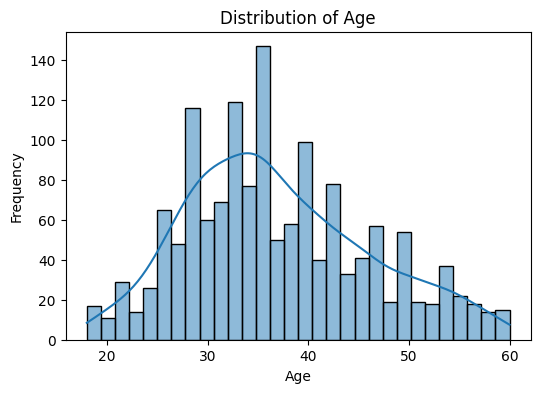

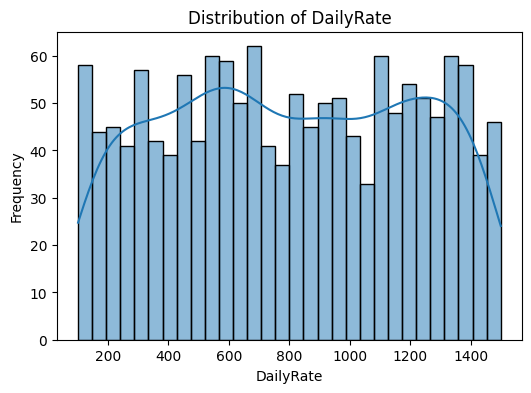

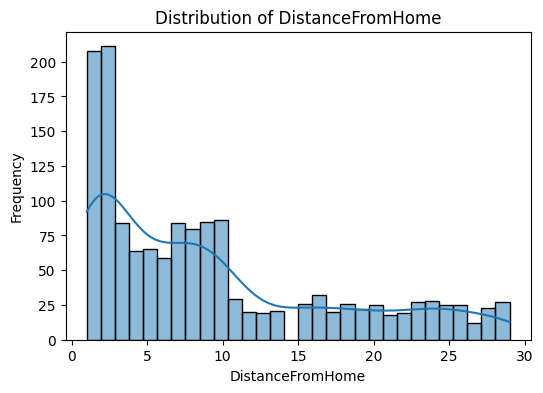

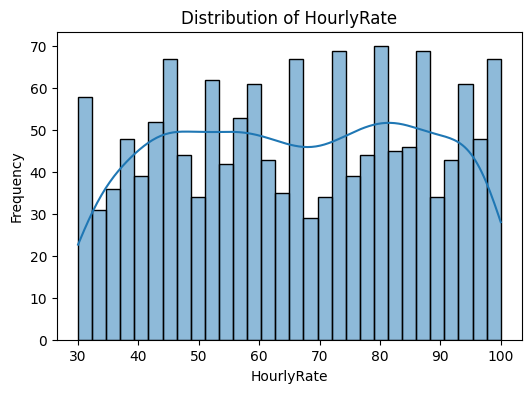

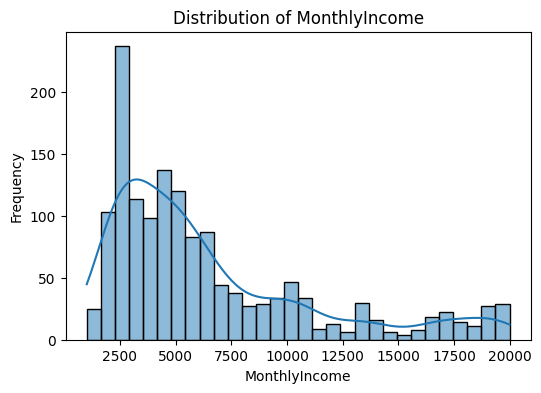

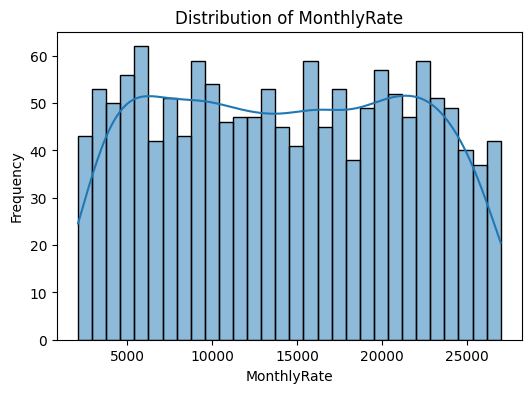

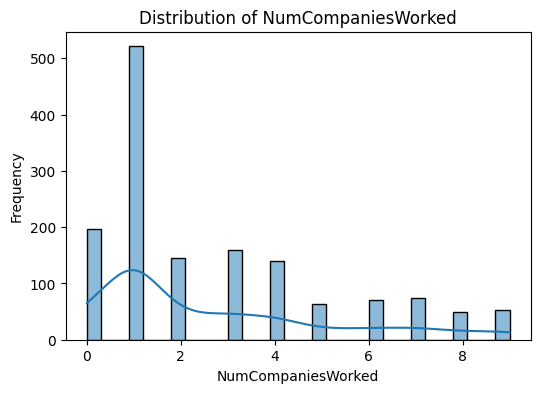

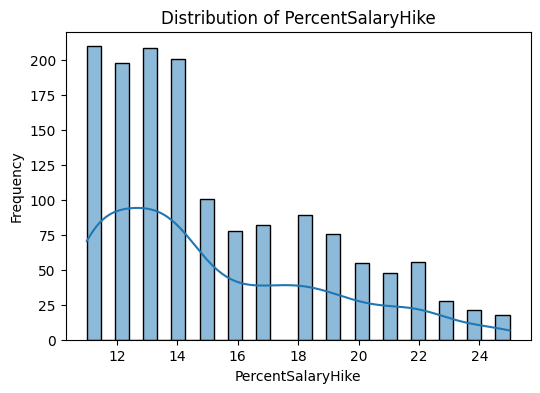

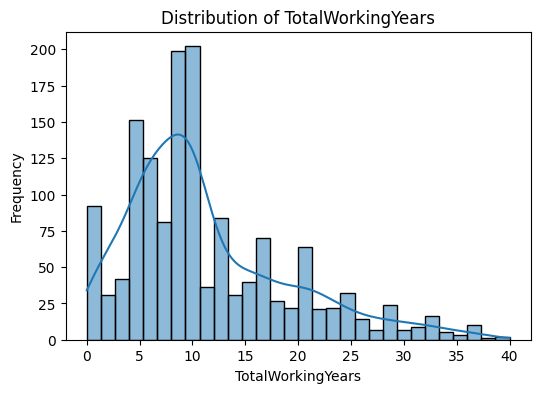

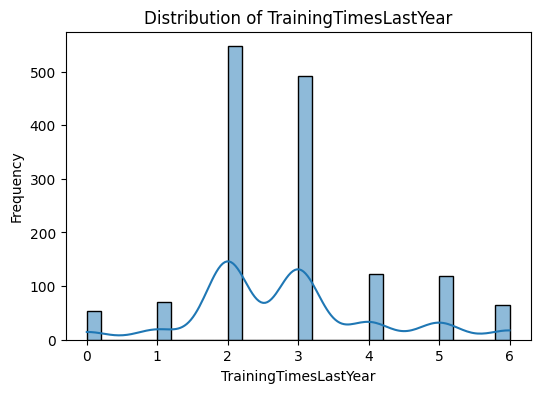

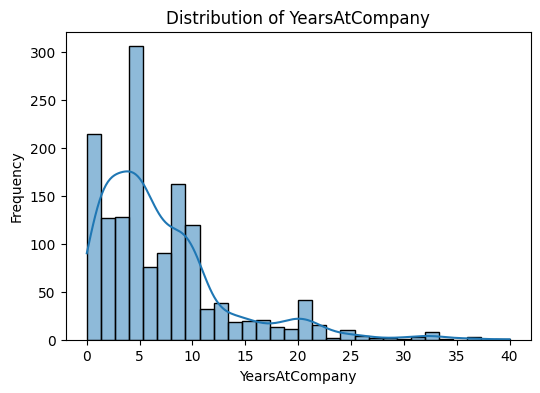

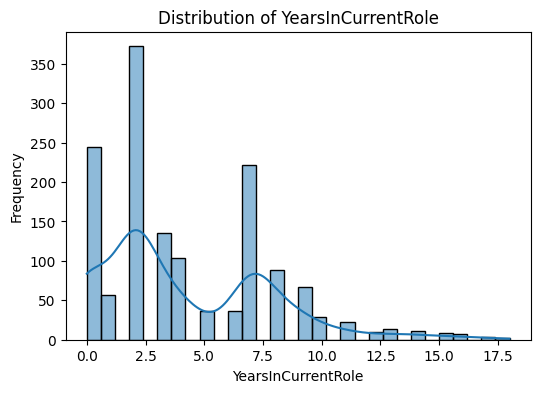

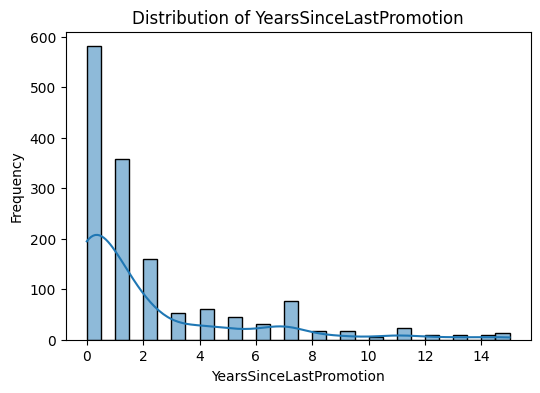

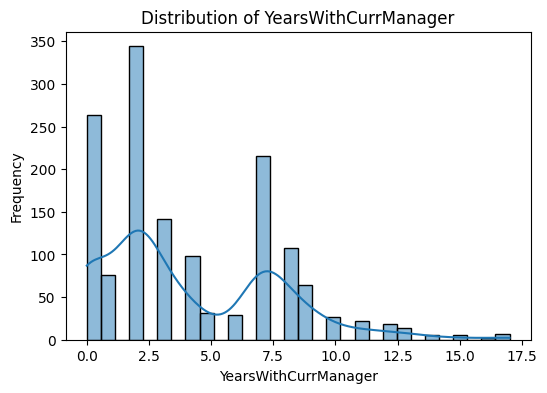

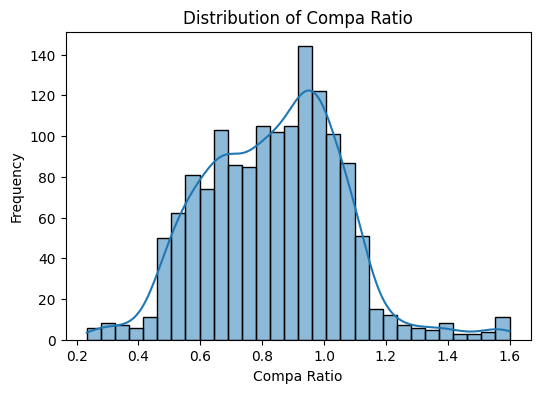

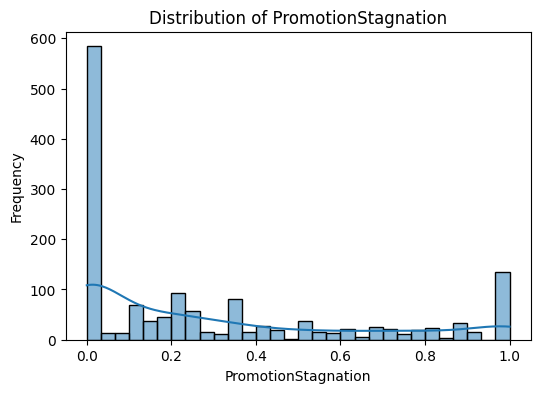

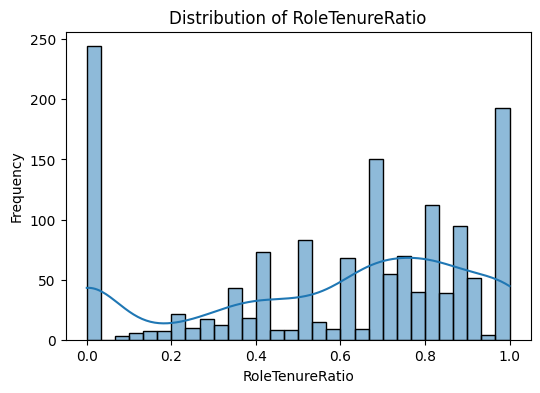

In [23]:
# Plot histograms
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [24]:
# Summary of object/categorical columns
print("\nSummary of Categorical Columns:")
print(df.describe(include=['object', 'category']))


Summary of Categorical Columns:
       Attrition BusinessTravel              Department  Education  \
count       1470           1470                    1470       1470   
unique         2              3                       3          5   
top           No  Travel_Rarely  Research & Development          3   
freq        1233           1043                     961        572   

       EducationField  EnvironmentSatisfaction Gender  JobInvolvement  \
count            1470                     1470   1470            1470   
unique              6                        4      2               4   
top     Life Sciences                        3   Male               3   
freq              606                      453    882             868   

        JobLevel          JobRole  JobSatisfaction MaritalStatus OverTime  \
count       1470             1470             1470          1470     1470   
unique         5                9                4             3        2   
top            1  S

In [25]:
# Labelling Ordinal Variables for better interpretability

education_map = {
    1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'
}

satisfaction_map = {
    1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'
}

job_involvement_map = {
    1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'
}

performance_map = {
    3: 'Average', 4: 'Good'
}

relationship_map = {
    1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'
}

wlb_map = {
    1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'
}

stock_option_map = {
    0: 'None', 1: 'Low', 2: 'Medium', 3: 'High'
}

job_level_map = {
    1: 'Entry Level', 2: 'Associate', 3: 'Middle Management',
    4: 'Senior Management', 5: 'Executive'
}

# Apply mappings
df['Education'] = df['Education'].map(education_map)
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].map(satisfaction_map)
df['JobInvolvement'] = df['JobInvolvement'].map(job_involvement_map)
df['JobSatisfaction'] = df['JobSatisfaction'].map(satisfaction_map)
df['PerformanceRating'] = df['PerformanceRating'].map(performance_map)
df['RelationshipSatisfaction'] = df['RelationshipSatisfaction'].map(relationship_map)
df['WorkLifeBalance'] = df['WorkLifeBalance'].map(wlb_map)
df['StockOptionLevel'] = df['StockOptionLevel'].map(stock_option_map)
df['JobLevel'] = df['JobLevel'].map(job_level_map)


**Count plots for categorical variables**

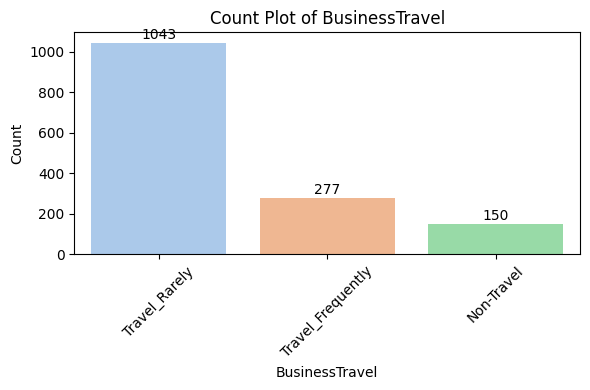

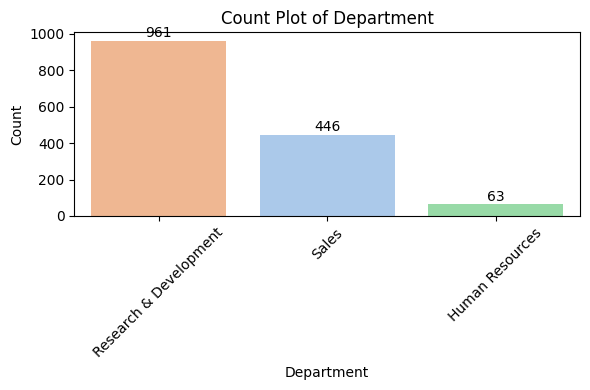

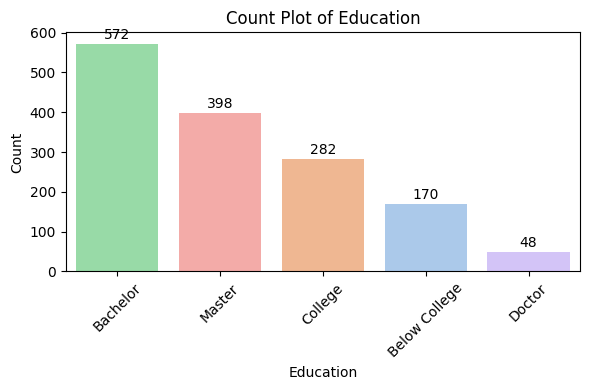

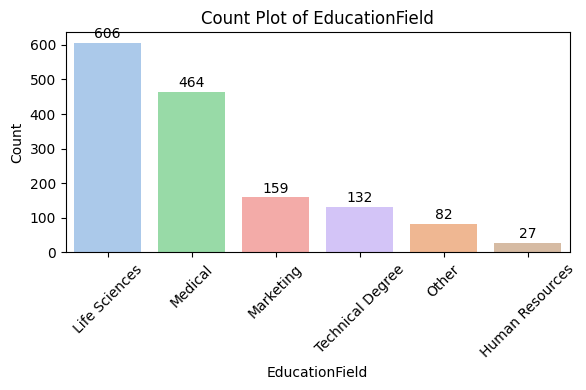

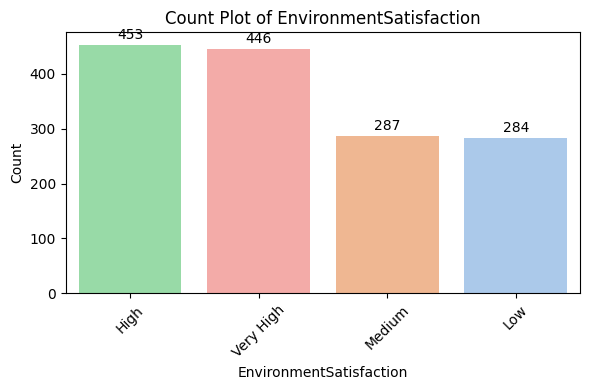

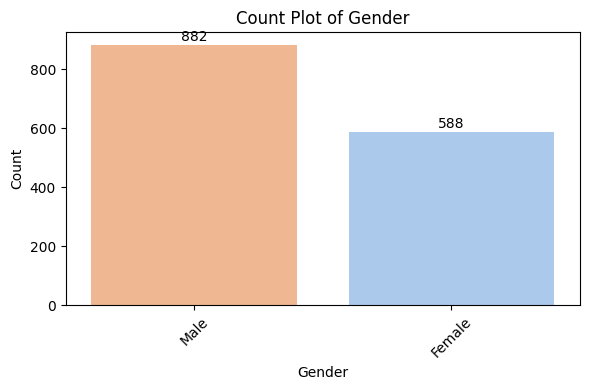

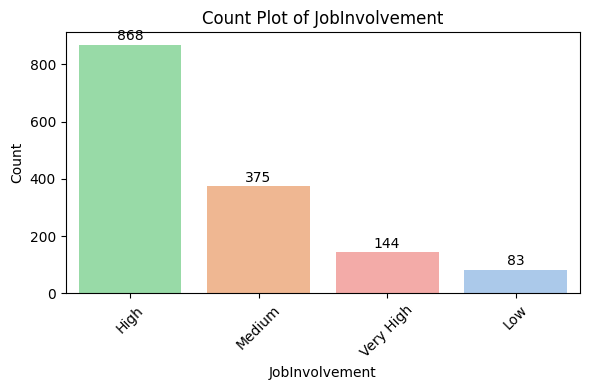

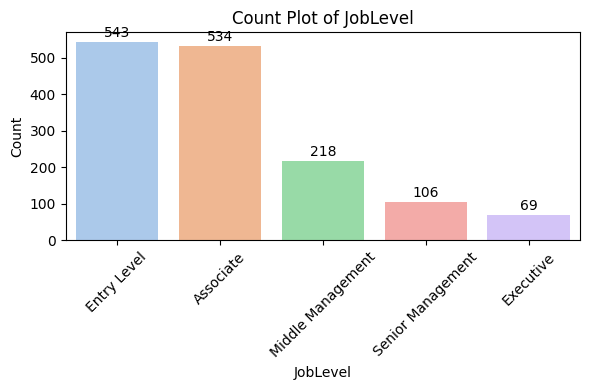

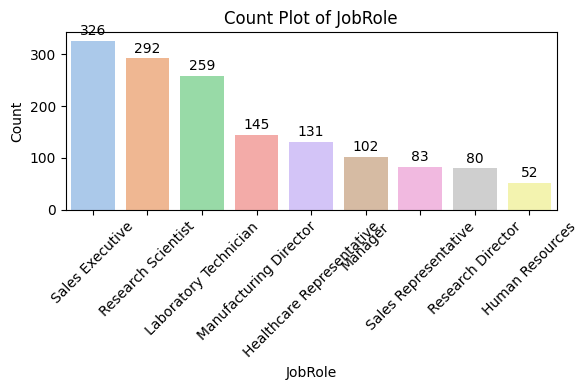

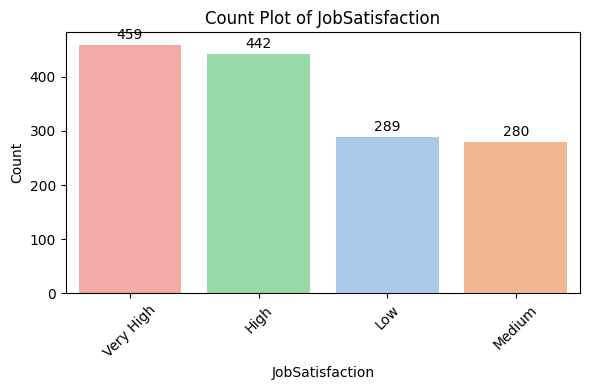

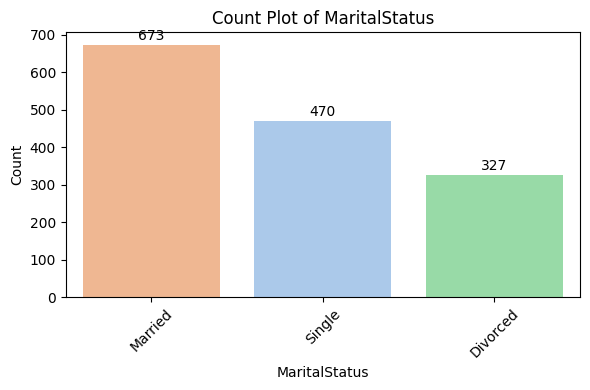

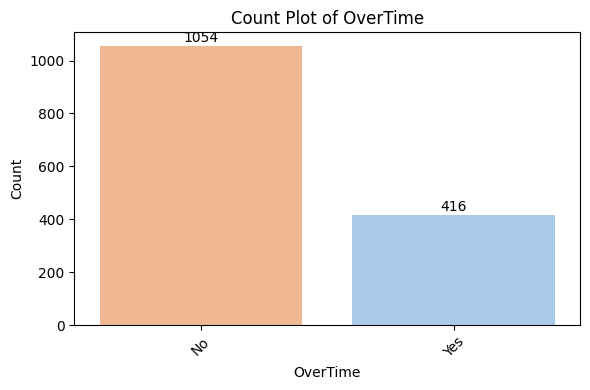

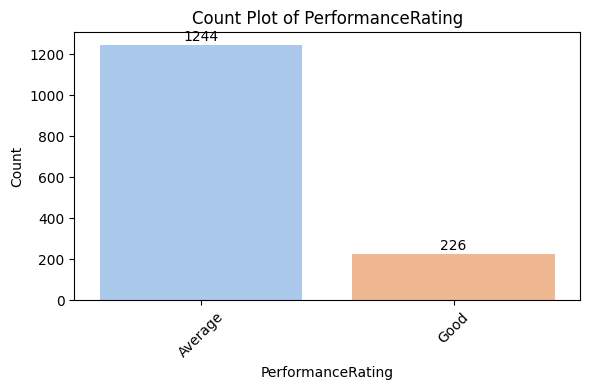

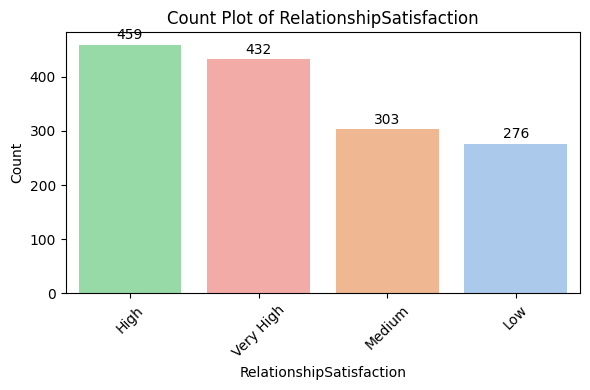

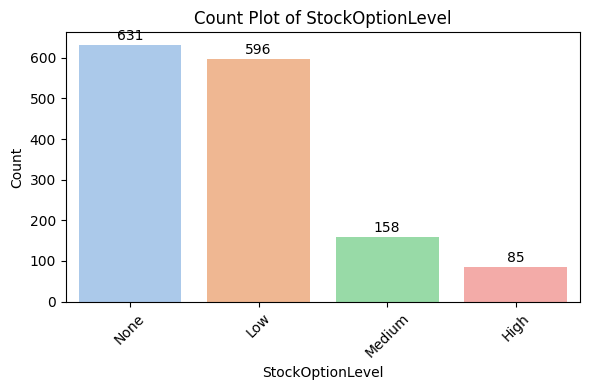

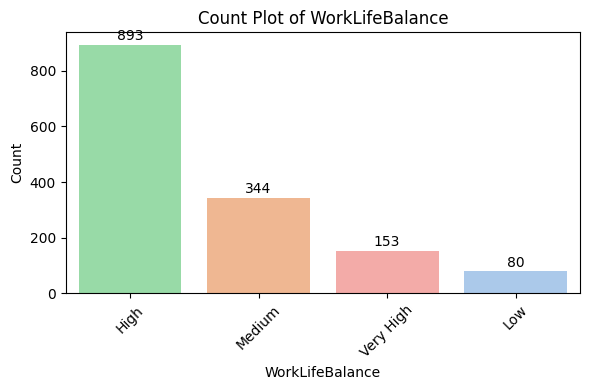

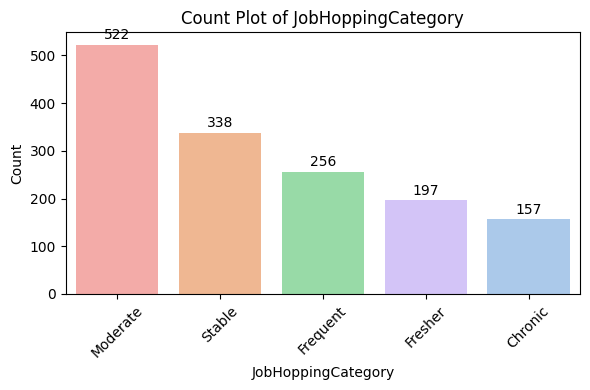

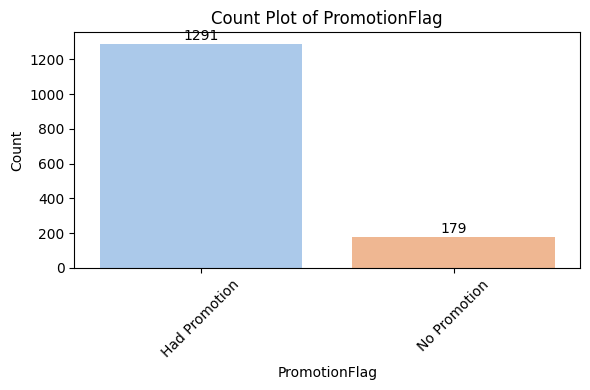

In [26]:
# Drop 'Attrition' from the list of categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Attrition' in categorical_cols:
    categorical_cols.remove('Attrition')

# Generate count plots for each categorical column
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=df, x=col, hue=col, legend=False,
                       order=df[col].value_counts().index, palette='pastel')
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Add count labels on each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 5,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

**Step 2: Target Variable - Class Imbalance**

In [27]:
# Value counts for the target variable
attrition_counts = df['Attrition'].value_counts()
attrition_percent = df['Attrition'].value_counts(normalize=True) * 100

# Combine into a summary table
attrition_summary = pd.DataFrame({
    'Count': attrition_counts,
    'Percentage': attrition_percent.round(2)
})

print("Attrition Distribution (Target Class):")
print(attrition_summary)


Attrition Distribution (Target Class):
           Count  Percentage
Attrition                   
No          1233       83.88
Yes          237       16.12


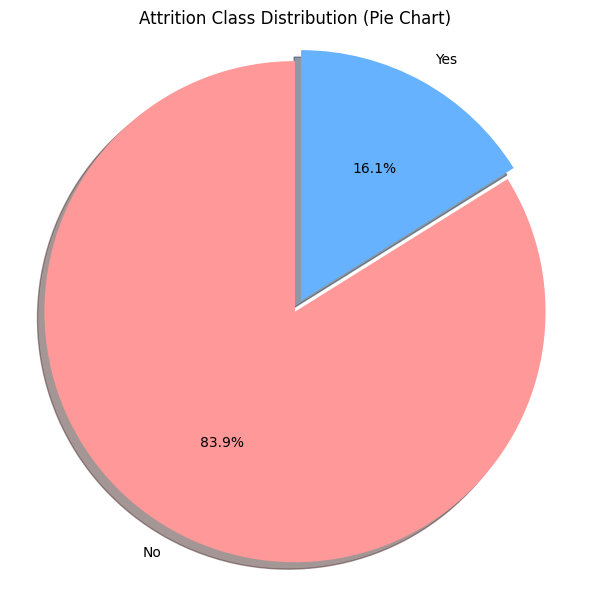

In [28]:
# Count and percentage for class labels
class_counts = df['Attrition'].value_counts()
labels = class_counts.index
sizes = class_counts.values
colors = ['#FF9999', '#66B2FF']  # pastel red and blue
explode = (0.05, 0)  # Slight explode for first slice (usually "No")

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        explode=explode,
        shadow=True)
plt.title('Attrition Class Distribution (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures a circle
plt.tight_layout()
plt.show()

The dataset has a clear class imbalance, with only ~16% of employees labeled as having left the organization. We will address this during the modeling phase using techniques such as SMOTE (Synthetic Minority Oversampling Technique), undersampling, Oversampling etc.

**Step 3: Missing Values & Descriptive Stats**

In [29]:
# 1. Total missing values per column
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

print("Columns with Missing Values:\n")
print(missing_summary)

Columns with Missing Values:

Series([], dtype: int64)


Data is clean: No missing values, no invalid categories, and constant columns have been removed.

**Descriptive statistics for numerical columns**

In [30]:
# 2. Descriptive statistics for numerical columns
desc_stats = df.describe().T

# 3. Add skewness and missing count to the stats
desc_stats['missing'] = df.isnull().sum()
desc_stats['skewness'] = df.skew(numeric_only=True)

print("\nDescriptive Statistics with Missing and Skewness:\n")
desc_stats = desc_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing', 'skewness']]
desc_stats.round(2)


Descriptive Statistics with Missing and Skewness:



,count,mean,std,min,25%,50%,75%,max,missing,skewness
Age,1470.0,36.92,9.14,18.00,30.00,36.00,43.00,60.0,0,0.41
DailyRate,1470.0,802.49,403.51,102.00,465.00,802.00,1157.00,1499.0,0,-0.00
DistanceFromHome,1470.0,9.19,8.11,1.00,2.00,7.00,14.00,29.0,0,0.96
HourlyRate,1470.0,65.89,20.33,30.00,48.00,66.00,83.75,100.0,0,-0.03
MonthlyIncome,1470.0,6502.93,4707.96,1009.00,2911.00,4919.00,8379.00,19999.0,0,1.37
MonthlyRate,1470.0,14313.10,7117.79,2094.00,8047.00,14235.50,20461.50,26999.0,0,0.02
NumCompaniesWorked,1470.0,2.69,2.50,0.00,1.00,2.00,4.00,9.0,0,1.03
PercentSalaryHike,1470.0,15.21,3.66,11.00,12.00,14.00,18.00,25.0,0,0.82
TotalWorkingYears,1470.0,11.28,7.78,0.00,6.00,10.00,15.00,40.0,0,1.12
TrainingTimesLastYear,1470.0,2.80,1.29,0.00,2.00,3.00,3.00,6.0,0,0.55


No missing values were found across all columns — confirming the dataset is clean and ready for modeling.

Most variables show acceptable levels of symmetry (skewness between -0.5 and +0.5), such as DailyRate, HourlyRate, and Compa Ratio, indicating a relatively normal distribution.

However, several variables exhibit moderate to high positive skewness. These right-skewed distributions suggest a concentration of lower values with a long tail on the higher end. Skewness can negatively impact the performance and interpretability of logistic regression models, especially when numerical features are used directly.

**Step 4: Outlier Detection**

In [31]:
# Only select numeric columns (exclude categorical or object types)
numeric_cols = df.select_dtypes(include=['number']).columns

# Final list of columns to check (continuous numeric features only)
columns_to_check = [
    col for col in numeric_cols
    if col not in ordinal_cols  # exclude manually flagged ordinal features
]

# Tukey method for outlier count
def count_outliers_tukey(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

#Calculate outlier count and % for each feature
total_rows = len(df)
outlier_summary = pd.DataFrame([
    {
        'Feature': col,
        'Outlier Count': count_outliers_tukey(df[col]),
        'Outlier %': round((count_outliers_tukey(df[col]) / total_rows) * 100, 2)
    }
    for col in columns_to_check
])

# Sort by % descending for clarity
outlier_summary.sort_values(by='Outlier %', ascending=False, inplace=True)

print("Outlier Summary:\n")
print(outlier_summary)

Outlier Summary:

                    Feature  Outlier Count  Outlier %
9     TrainingTimesLastYear            238      16.19
4             MonthlyIncome            114       7.76
12  YearsSinceLastPromotion            107       7.28
10           YearsAtCompany            104       7.07
8         TotalWorkingYears             63       4.29
6        NumCompaniesWorked             52       3.54
11       YearsInCurrentRole             21       1.43
14              Compa Ratio             18       1.22
13     YearsWithCurrManager             14       0.95
0                       Age              0       0.00
7         PercentSalaryHike              0       0.00
2          DistanceFromHome              0       0.00
3                HourlyRate              0       0.00
1                 DailyRate              0       0.00
5               MonthlyRate              0       0.00
15      PromotionStagnation              0       0.00
16          RoleTenureRatio              0       0.00


Outlier analysis using Tukey’s method revealed that features like TrainingTimesLastYear (16.2%), JobHoppingIndex (10.7%), and MonthlyIncome (7.8%) had the highest proportion of outliers, indicating potential behavioral or compensation-driven variability. Other tenure-related features such as YearsSinceLastPromotion and YearsAtCompany also showed moderate outlier presence. Several features, including Age, DistanceFromHome, and PromotionStagnation, had no outliers, supporting the robustness of data selection for outlier detection.

Outliers will be handled later in the process when modelling for regression.

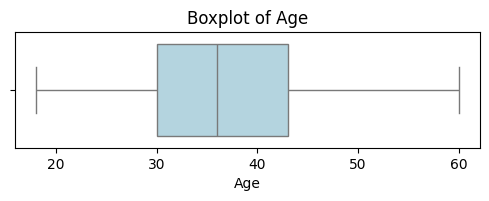

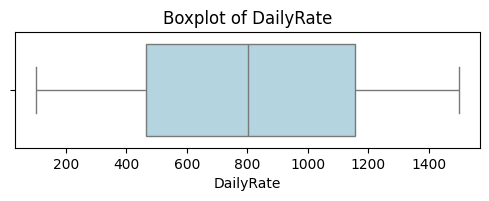

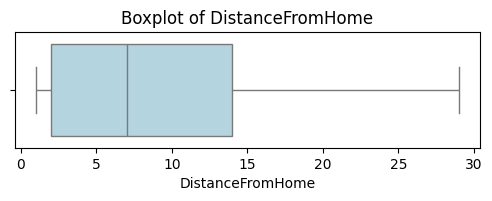

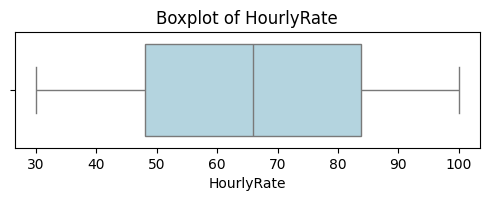

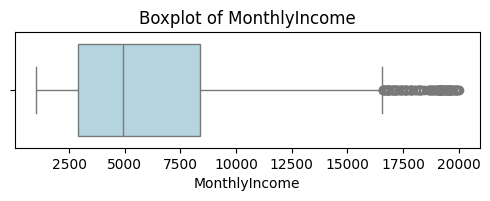

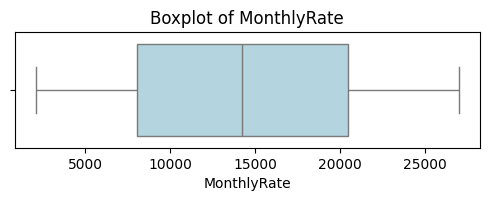

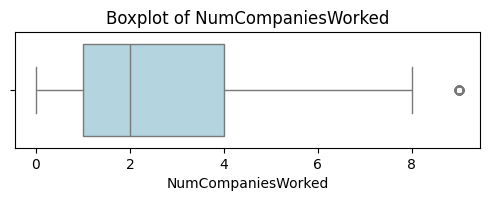

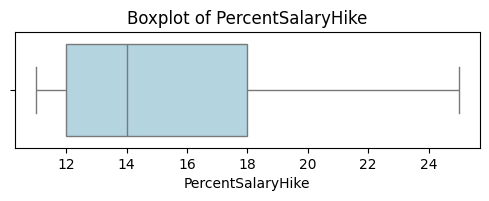

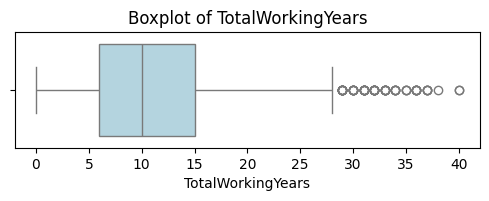

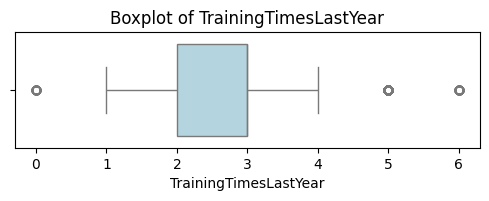

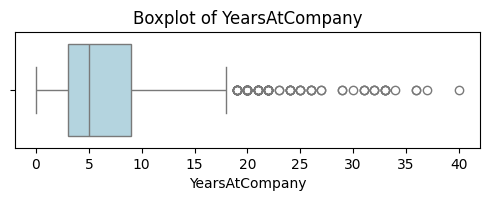

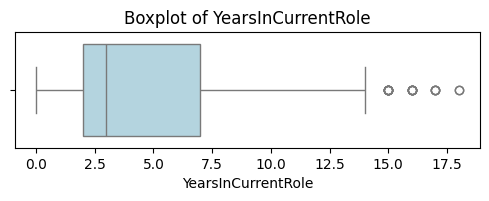

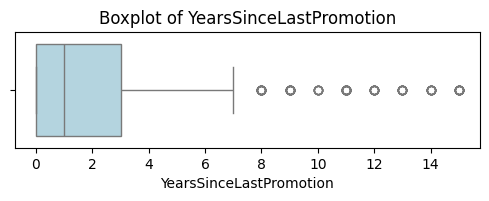

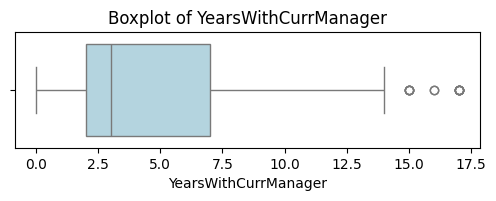

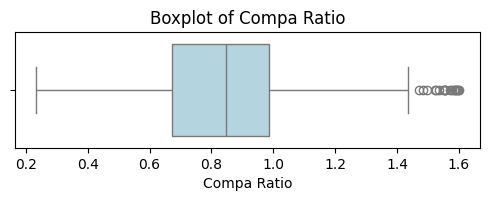

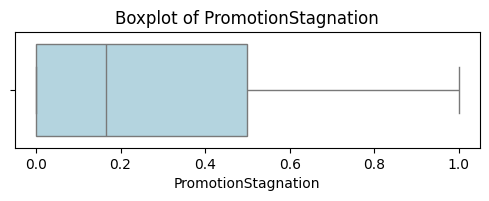

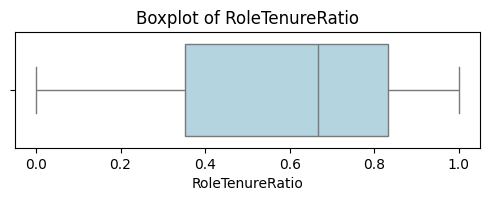

In [32]:
# Plot individual boxplots
for col in columns_to_check:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()


Outliers in these features are not treated as errors — they reflect real-world HR conditions (e.g., long tenure, high job-hopping) and may be predictive of attrition.

Step 5: Correlation Analysis


In [33]:
# Select only numeric features for correlation analysis
numeric_df = df.select_dtypes(include=['int64', 'float64'])

In [34]:
# Compute the correlation matrix
correlation_matrix = numeric_df.corr()


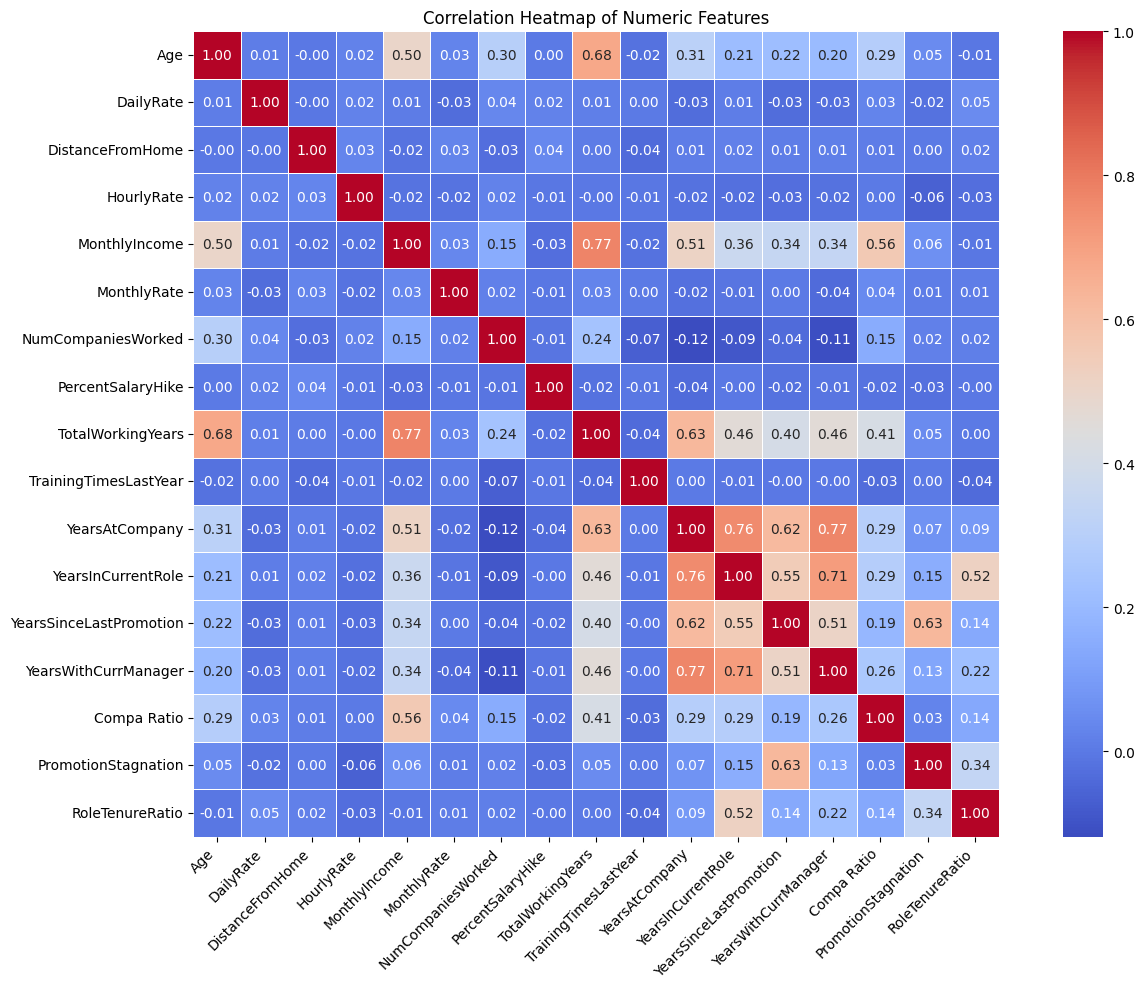

In [35]:
# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
# Calculate correlation matrix
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr().abs()

# Unstack the correlation matrix and reset index
high_corr_pairs = (
    corr_matrix.unstack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)

# Remove self-correlations and duplicate pairs
high_corr_pairs = high_corr_pairs[high_corr_pairs['Feature1'] != high_corr_pairs['Feature2']]
high_corr_pairs['Sorted'] = high_corr_pairs.apply(lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)
high_corr_pairs = high_corr_pairs.drop_duplicates(subset='Sorted').drop(columns='Sorted')

# Filter for high correlation pairs (greater than 0.7)
strong_corr = high_corr_pairs[high_corr_pairs['Correlation'] > 0.7]

# Sort by descending correlation
strong_corr = strong_corr.sort_values(by='Correlation', ascending=False)

print("Highly correlated pairs (>|0.7|):")
print(strong_corr)


Highly correlated pairs (>|0.7|):
               Feature1              Feature2  Correlation
76        MonthlyIncome     TotalWorkingYears     0.772893
183      YearsAtCompany  YearsWithCurrManager     0.769212
181      YearsAtCompany    YearsInCurrentRole     0.758754
200  YearsInCurrentRole  YearsWithCurrManager     0.714365


Identified highy correlated pairs, removal of which one from data set will be made based on its respective correlation with target variable which will be identifed through biserial correlation.

In [37]:
from scipy.stats import pointbiserialr

# Convert Attrition to binary: Yes = 1, No = 0
df['Attrition_binary'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# List of numeric features to check
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('Attrition_binary')

# Calculate point biserial correlation
pb_results = {
    feature: pointbiserialr(df['Attrition_binary'], df[feature])[0]
    for feature in numeric_features
}

# Create sorted DataFrame
pb_df = pd.DataFrame(pb_results.items(), columns=['Feature', 'PointBiserialCorr']).sort_values(
    by='PointBiserialCorr', key=abs, ascending=False)

print(pb_df)


                    Feature  PointBiserialCorr
8         TotalWorkingYears          -0.171063
11       YearsInCurrentRole          -0.160545
4             MonthlyIncome          -0.159840
0                       Age          -0.159205
13     YearsWithCurrManager          -0.156199
14              Compa Ratio          -0.153154
10           YearsAtCompany          -0.134392
16          RoleTenureRatio          -0.130324
2          DistanceFromHome           0.077924
9     TrainingTimesLastYear          -0.059478
1                 DailyRate          -0.056652
6        NumCompaniesWorked           0.043494
12  YearsSinceLastPromotion          -0.033019
15      PromotionStagnation           0.031539
5               MonthlyRate           0.015170
7         PercentSalaryHike          -0.013478
3                HourlyRate          -0.006846


In [38]:
# Drop features with comments explaining why each was removed

columns_to_drop_with_reasons = {
    'TotalWorkingYears': "Highly correlated with MonthlyIncome (r = 0.77). While it has a slightly stronger correlation with Attrition (r = -0.1711), it is less actionable than MonthlyIncome, which is retained.",
    'YearsWithCurrManager': "Highly correlated with YearsAtCompany (r = 0.77) and YearsInCurrentRole (r = 0.71). Among the three, it has the weakest correlation with Attrition (r = -0.1562), so it is dropped.",
    'YearsAtCompany': "Correlated with both YearsInCurrentRole (r = 0.76) and YearsWithCurrManager (r = 0.77). It has the lowest predictive signal (r = -0.1344) among the three, so it's excluded in favor of YearsInCurrentRole.",
    'YearsSinceLastPromotion': "Dropped due to redundancy—PromotionStagnation is a derived and more interpretable feature. Both have very weak correlation with Attrition (r ≈ ±0.03), but PromotionStagnation is retained for simplicity and stakeholder clarity.",
    'NumCompaniesWorked': "Dropped in favor of JobHoppingIndex, a derived feature with stronger correlation to Attrition (r = 0.2259 vs. 0.0435). JobHoppingIndex better captures the pattern of frequent job changes, which is more predictive and interpretable."
}

# Print reasons before dropping
print("Dropping the following columns with reasons:")
for col, reason in columns_to_drop_with_reasons.items():
    print(f"- {col}: {reason}")

# Drop the columns
df = df.drop(columns=columns_to_drop_with_reasons.keys())

# Show updated column count
print(f"\nRemaining columns: {df.shape[1]}")
df.columns.tolist()


Dropping the following columns with reasons:
- TotalWorkingYears: Highly correlated with MonthlyIncome (r = 0.77). While it has a slightly stronger correlation with Attrition (r = -0.1711), it is less actionable than MonthlyIncome, which is retained.
- YearsWithCurrManager: Highly correlated with YearsAtCompany (r = 0.77) and YearsInCurrentRole (r = 0.71). Among the three, it has the weakest correlation with Attrition (r = -0.1562), so it is dropped.
- YearsAtCompany: Correlated with both YearsInCurrentRole (r = 0.76) and YearsWithCurrManager (r = 0.77). It has the lowest predictive signal (r = -0.1344) among the three, so it's excluded in favor of YearsInCurrentRole.
- YearsSinceLastPromotion: Dropped due to redundancy—PromotionStagnation is a derived and more interpretable feature. Both have very weak correlation with Attrition (r ≈ ±0.03), but PromotionStagnation is retained for simplicity and stakeholder clarity.
- NumCompaniesWorked: Dropped in favor of JobHoppingIndex, a derived 

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsInCurrentRole',
 'Compa Ratio',
 'PromotionStagnation',
 'RoleTenureRatio',
 'JobHoppingCategory',
 'PromotionFlag',
 'Attrition_binary']

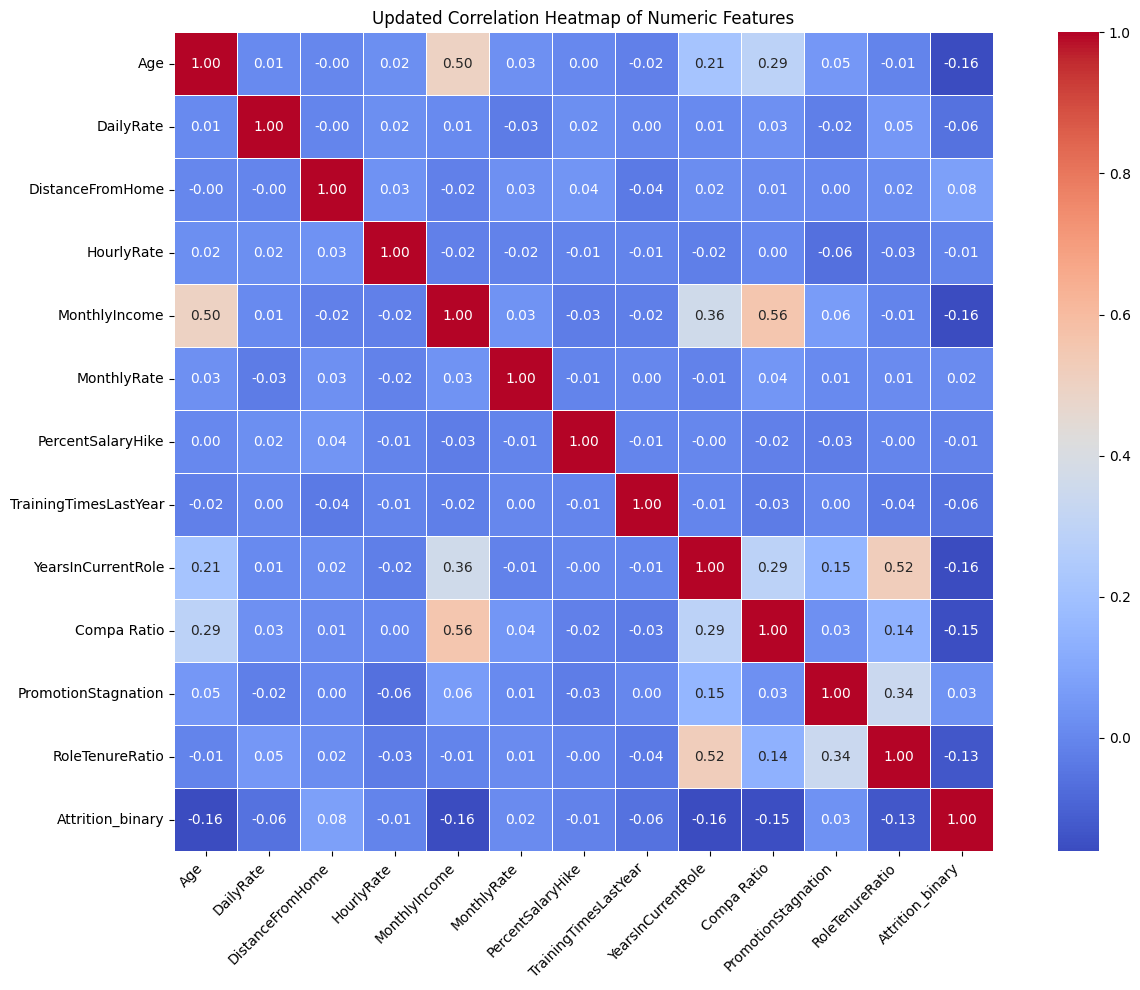

In [39]:
# Select numeric columns for correlation check
numeric_df_updated = df.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
correlation_matrix_updated = numeric_df_updated.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_updated, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Updated Correlation Heatmap of Numeric Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Confirmation that Multicollinearity doesnt exist in the data set.

Step 6: Chi Square Analysis

In [40]:
from scipy.stats import chi2_contingency

In [41]:
# Convert Attrition to binary (if not already done)
df['Attrition_binary'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Identify categorical columns (object or category dtypes), excluding 'Attrition'
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Attrition']

# Run Chi-square test between each categorical feature and Attrition
chi2_results = []

for col in categorical_cols:
    contingency = pd.crosstab(df[col], df['Attrition'])
    try:
        chi2, p, dof, expected = chi2_contingency(contingency)
        chi2_results.append((col, p))
    except ValueError:
        chi2_results.append((col, None))  # For variables that cause errors

# Create results DataFrame
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'p_value'])
chi2_df['Significant'] = chi2_df['p_value'] < 0.05
chi2_df = chi2_df.sort_values(by='p_value')

In [42]:
# Show in notebook
print("Chi-Square Test Results (vs Attrition):\n")
print(chi2_df)

Chi-Square Test Results (vs Attrition):

                     Feature       p_value  Significant
11                  OverTime  8.158424e-21         True
16        JobHoppingCategory  5.868598e-17         True
8                    JobRole  2.752482e-15         True
7                   JobLevel  6.634685e-15         True
14          StockOptionLevel  4.379390e-13         True
10             MaritalStatus  9.455511e-11         True
6             JobInvolvement  2.863181e-06         True
0             BusinessTravel  5.608614e-06         True
17             PromotionFlag  2.046011e-05         True
4    EnvironmentSatisfaction  5.123469e-05         True
9            JobSatisfaction  5.563005e-04         True
15           WorkLifeBalance  9.725699e-04         True
1                 Department  4.525607e-03         True
3             EducationField  6.773980e-03         True
13  RelationshipSatisfaction  1.549724e-01        False
5                     Gender  2.905724e-01        False
2      

In [43]:
# Drop redundant and non-significant categorical columns
columns_to_drop_categorical = [
    'Gender',    # Not significantly associated with Attrition
    'RelationshipSatisfaction',
    'Education',
    'PerformanceRating'
]
df.drop(columns=columns_to_drop_categorical, inplace=True)

Correlation and Chi-Square tests help remove variables which are either highly collinear with others (leading to multicollinearity) or statistically unrelated to the target variable. By eliminating such variables, we reduce noise, improve model stability, and enhance interpretability

# Decison Trees

# Model Setup

For Tree Models

In [44]:
# Step 0: Binary target variable
df_Trees['Attrition_binary'] = df_Trees['Attrition'].map({'Yes': 1, 'No': 0})
y_Trees = df_Trees['Attrition_binary']
X_Trees = df_Trees.drop(columns=['Attrition', 'Attrition_binary'])

In [45]:
# Step 1: Identify categorical columns
categorical_cols = X_Trees.select_dtypes(include='object').columns

# Step 2: One-hot encode only the categorical columns and drop originals
X_Trees_encoded = pd.get_dummies(X_Trees, columns=categorical_cols, drop_first=True)

In [46]:
# Step 3: Train-test split
from sklearn.model_selection import train_test_split

X_train_Trees, X_test_Trees, y_train_Trees, y_test_Trees = train_test_split(
    X_Trees_encoded, y_Trees, test_size=0.3, stratify=y_Trees, random_state=1
)

In [47]:
# Step 4: Confirm shape and class balance
print("Train shape:", X_train_Trees.shape)
print("Test shape:", X_test_Trees.shape)
print("Train target balance:\n", y_train_Trees.value_counts())
print("Test target balance:\n", y_test_Trees.value_counts())

Train shape: (1029, 52)
Test shape: (441, 52)
Train target balance:
 Attrition_binary
0    863
1    166
Name: count, dtype: int64
Test target balance:
 Attrition_binary
0    370
1     71
Name: count, dtype: int64


In [48]:
# Required libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_sample_weight

In [49]:
# Define evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return f1, auc

Finalising a target balancing approach - trying 4 different approaches

In [50]:
# Container for results
results = []

In [51]:
# 1. SMOTE
smote = SMOTE(random_state=1)
X_train_sm_Trees, y_train_sm_Trees = smote.fit_resample(X_train_Trees, y_train_Trees)

model_2 = DecisionTreeClassifier(random_state=1)
model_2.fit(X_train_sm_Trees, y_train_sm_Trees)

f1, auc = evaluate_model(model_2, X_test_Trees, y_test_Trees)
results.append(("SMOTE (Full Features)", f1, auc))

In [52]:
# 2. Random Oversampling
ros = RandomOverSampler(random_state=1)
X_train_ros_Trees, y_train_ros_Trees = ros.fit_resample(X_train_Trees, y_train_Trees)

model_3 = DecisionTreeClassifier(random_state=1)
model_3.fit(X_train_ros_Trees, y_train_ros_Trees)

f1, auc = evaluate_model(model_3, X_test_Trees, y_test_Trees)
results.append(("Random Oversampling (Full Features)", f1, auc))

In [53]:
# 3. Random Undersampling
rus = RandomUnderSampler(random_state=1)
X_train_rus_Trees, y_train_rus_Trees = rus.fit_resample(X_train_Trees, y_train_Trees)

model_4 = DecisionTreeClassifier(random_state=1)
model_4.fit(X_train_rus_Trees, y_train_rus_Trees)

f1, auc = evaluate_model(model_4, X_test_Trees, y_test_Trees)
results.append(("Random Undersampling (Full Features)", f1, auc))

In [54]:
# 4. Class Weighting
model_5 = DecisionTreeClassifier(class_weight='balanced', random_state=1)
model_5.fit(X_train_Trees, y_train_Trees)

f1, auc = evaluate_model(model_5, X_test_Trees, y_test_Trees)
results.append(("Class Weight = Balanced (Full Features)", f1, auc))


In [55]:
# Show results
results_df = pd.DataFrame(results, columns=['Rebalancing Method', 'F1 Score', 'ROC AUC'])
results_df.sort_values(by='F1 Score', ascending=False, inplace=True)

In [56]:
results_df

,Rebalancing Method,F1 Score,ROC AUC
0,SMOTE (Full Features),0.351515,0.616388
1,Random Oversampling (Full Features),0.351351,0.614180
2,Random Undersampling (Full Features),0.330508,0.604378
3,Class Weight = Balanced (Full Features),0.269504,0.564884


SMOTE performed better compared to other rebalancing techniques

## Decision Tree using SMOTE

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

In [58]:
# Rebalance the training set using SMOTE
smote = SMOTE(random_state=1)
X_train_smote_final, y_train_smote_final = smote.fit_resample(X_train_Trees, y_train_Trees)

# Train the final decision tree
final_tree = DecisionTreeClassifier(random_state=1)
final_tree.fit(X_train_smote_final, y_train_smote_final)

DecisionTreeClassifier(random_state=1)

In [59]:
# Evaluate model on full-feature tree test set
y_pred = final_tree.predict(X_test_Trees)

# Classification report
report = classification_report(y_test_Trees, y_pred, output_dict=True)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_Trees, y_pred)


In [60]:
# Format classification report as a DataFrame
report_df = pd.DataFrame(report).transpose()

# Format confusion matrix as a labeled DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    columns=["Predicted: No", "Predicted: Yes"],
    index=["Actual: No", "Actual: Yes"]
)

# Display results
print("Classification Report:")
display(report_df)

print("Confusion Matrix:")
display(conf_matrix_df)


Classification Report:


,precision,recall,f1-score,support
0,0.878963,0.824324,0.850767,370.00000
1,0.308511,0.408451,0.351515,71.00000
accuracy,0.757370,0.757370,0.757370,0.75737
macro avg,0.593737,0.616388,0.601141,441.00000
weighted avg,0.787121,0.757370,0.770389,441.00000


Confusion Matrix:


,Predicted: No,Predicted: Yes
Actual: No,305,65
Actual: Yes,42,29


In [61]:
# Container to hold ROC AUC and F1 scores for all models
roc_auc_scores = {}
f1_scores = {}

In [62]:
# Predict probabilities and class labels
y_prob = final_tree.predict_proba(X_test_Trees)[:, 1]
y_pred = final_tree.predict(X_test_Trees)

# Compute ROC AUC
roc_auc = roc_auc_score(y_test_Trees, y_prob)
roc_auc_scores['Decision Tree'] = round(roc_auc, 4)

# Compute F1 Score
f1 = f1_score(y_test_Trees, y_pred)
f1_scores['Decision Tree'] = round(f1, 4)

# Print both scores
print(f"Decision Tree ROC AUC: {roc_auc_scores['Decision Tree']}")
print(f"Decision Tree F1 Score: {f1_scores['Decision Tree']}")

Decision Tree ROC AUC: 0.6164
Decision Tree F1 Score: 0.3515


HyperParameter Tuning

In [63]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Define hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

# 2. GridSearchCV using AUC
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# 3. Fit on SMOTEd training data
grid_search.fit(X_train_smote_final, y_train_smote_final)
best_tree_auc = grid_search.best_estimator_

# 4. Predict on test set
y_pred = best_tree_auc.predict(X_test_Trees)
y_proba = best_tree_auc.predict_proba(X_test_Trees)[:, 1]

# 5. Compute metrics
auc_score = roc_auc_score(y_test_Trees, y_proba)
f1 = f1_score(y_test_Trees, y_pred)

# 6. Print results
print("✅ Decision Tree (SMOTE + AUC-Tuned)")
print(f"🔹 ROC AUC Score: {auc_score:.3f}")
print(f"🔹 F1 Score (Threshold = 0.5): {f1:.3f}")
print(f"🔹 Best Hyperparameters: {grid_search.best_params_}")
print("🔹 Predicted class distribution:", np.bincount(y_pred))

# 7. Store in containers
roc_auc_scores['Decision Tree (Tuned + SMOTE + AUC)'] = round(auc_score, 4)
f1_scores['Decision Tree (Tuned + SMOTE + AUC)'] = round(f1, 4)

✅ Decision Tree (SMOTE + AUC-Tuned)
🔹 ROC AUC Score: 0.743
🔹 F1 Score (Threshold = 0.5): 0.000
🔹 Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
🔹 Predicted class distribution: [441]


Tree Visualisation

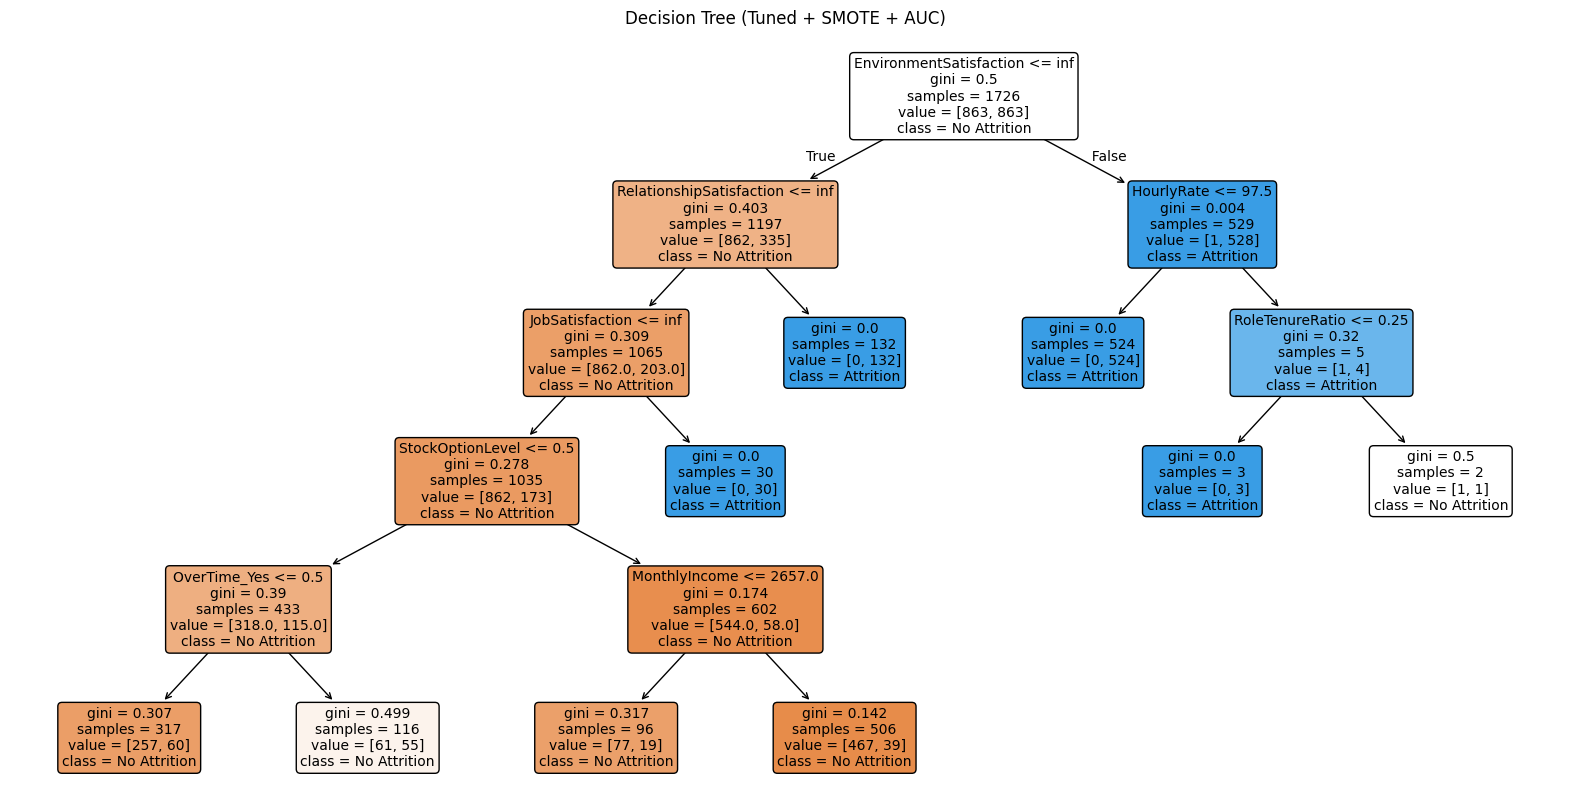

In [64]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Optional: If your data has column names
feature_names = X_train_smote_final.columns
class_names = ['No Attrition', 'Attrition']

# Set plot size
plt.figure(figsize=(20, 10))

# Visualize the tree
plot_tree(
    best_tree_auc,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10
)

plt.title("Decision Tree (Tuned + SMOTE + AUC)")
plt.show()

Trying Random Forest with SMOTE, which is often more robust than a single Decision Tree, especially for class imbalance scenarios like attrition.

## **Random Forest**

In [65]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Apply SMOTE to full-feature training data
smote = SMOTE(random_state=1)
X_train_rf_sm, y_train_rf_sm = smote.fit_resample(X_train_Trees, y_train_Trees)

# 2. Train the Random Forest model (no need for class_weight)
rf_model = RandomForestClassifier(
    random_state=1,
    n_estimators=100,
    max_depth=None
)
rf_model.fit(X_train_rf_sm, y_train_rf_sm)

RandomForestClassifier(random_state=1)

Random Forest Evaluation (SMOTE):


,precision,recall,f1-score,support
0,0.876,0.992,0.930,370.000
1,0.864,0.268,0.409,71.000
accuracy,0.875,0.875,0.875,0.875
macro avg,0.870,0.630,0.669,441.000
weighted avg,0.874,0.875,0.846,441.000



🔹 ROC AUC Score: 0.828
🔹 F1 Score: 0.409


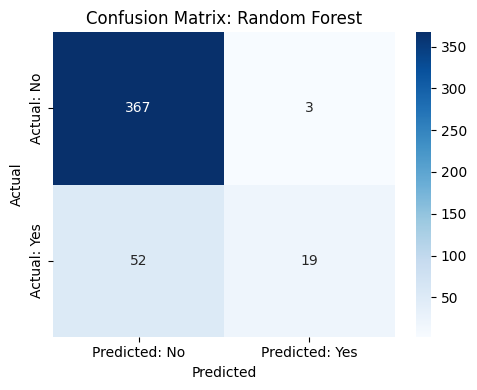

In [66]:
# 3. Evaluate on original test set
y_pred_rf = rf_model.predict(X_test_Trees)
y_prob_rf = rf_model.predict_proba(X_test_Trees)[:, 1]

# 4. Classification report (includes F1)
report = classification_report(y_test_Trees, y_pred_rf, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)

# 5. ROC AUC and F1
roc_auc = roc_auc_score(y_test_Trees, y_prob_rf)
f1_rf = f1_score(y_test_Trees, y_pred_rf)

# 5a. Display
print("Random Forest Evaluation (SMOTE):")
display(report_df)
print(f"\n🔹 ROC AUC Score: {roc_auc:.3f}")
print(f"🔹 F1 Score: {f1_rf:.3f}")

# 5b. Store in tracking containers
roc_auc_scores['Random Forest (SMOTE)'] = round(roc_auc, 4)
f1_scores['Random Forest (SMOTE)'] = round(f1_rf, 4)

# 6. Confusion Matrix
conf_matrix = confusion_matrix(y_test_Trees, y_pred_rf)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    columns=["Predicted: No", "Predicted: Yes"],
    index=["Actual: No", "Actual: Yes"]
)

# 7. Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Random Forest")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

## XGBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:16:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (Tuned with ROC AUC) - Classification Report:


,precision,recall,f1-score,support
0,0.895,0.946,0.920,370.000
1,0.600,0.423,0.496,71.000
accuracy,0.862,0.862,0.862,0.862
macro avg,0.748,0.684,0.708,441.000
weighted avg,0.848,0.862,0.852,441.000



🔹 ROC AUC Score: 0.8115
🔹 F1 Score: 0.4959
🔹 Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


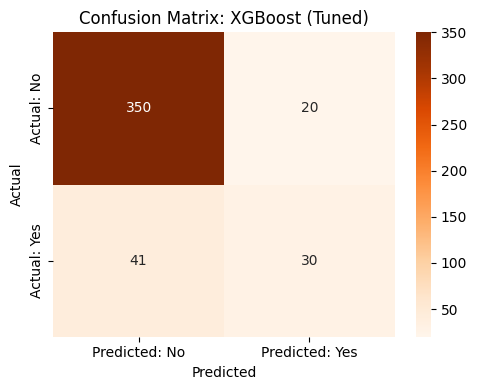

In [67]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Ensure categorical columns are numeric
X_train_Trees = X_train_Trees.apply(lambda col: col.cat.codes if col.dtypes.name == 'category' else col)
X_test_Trees = X_test_Trees.apply(lambda col: col.cat.codes if col.dtypes.name == 'category' else col)

# 2. Apply SMOTE
smote = SMOTE(random_state=1)
X_train_xgb_sm, y_train_xgb_sm = smote.fit_resample(X_train_Trees, y_train_Trees)

# 3. Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# 4. GridSearchCV with ROC AUC scoring
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 5. Fit on SMOTE-balanced data
grid_search.fit(X_train_xgb_sm, y_train_xgb_sm)

# 6. Best estimator
best_xgb = grid_search.best_estimator_

# 7. Predict on original test set
y_pred = best_xgb.predict(X_test_Trees)
y_prob = best_xgb.predict_proba(X_test_Trees)[:, 1]

# 8. Evaluation
report = classification_report(y_test_Trees, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
roc_auc = roc_auc_score(y_test_Trees, y_prob)
f1_xgb = f1_score(y_test_Trees, y_pred)

# 9. Display results
print("XGBoost (Tuned with ROC AUC) - Classification Report:")
display(report_df)
print(f"\n🔹 ROC AUC Score: {roc_auc:.4f}")
print(f"🔹 F1 Score: {f1_xgb:.4f}")
print(f"🔹 Best Hyperparameters: {grid_search.best_params_}")

# 10. Confusion matrix
conf_matrix = confusion_matrix(y_test_Trees, y_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    columns=["Predicted: No", "Predicted: Yes"],
    index=["Actual: No", "Actual: Yes"]
)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix: XGBoost (Tuned)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# 11. Log to containers
roc_auc_scores['XGBoost (Tuned + SMOTE)'] = round(roc_auc, 4)
f1_scores['XGBoost (Tuned + SMOTE)'] = round(f1_xgb, 4)


In [68]:
roc_auc_scores

{'Decision Tree': np.float64(0.6164),
 'Decision Tree (Tuned + SMOTE + AUC)': np.float64(0.7427),
 'Random Forest (SMOTE)': np.float64(0.8283),
 'XGBoost (Tuned + SMOTE)': np.float64(0.8115)}

In [69]:
f1_scores

{'Decision Tree': 0.3515,
 'Decision Tree (Tuned + SMOTE + AUC)': 0.0,
 'Random Forest (SMOTE)': 0.4086,
 'XGBoost (Tuned + SMOTE)': 0.4959}

## SHAP

The highest performing model in this case is Random Forest. So performing SHAP on it.

 96%|=================== | 845/882 [00:18<00:00]       

SHAP shape: (441, 52, 2)
🔍 Top 15 Features Influencing Attrition (Class 1):


,Feature,Mean_Abs_SHAP
14,RelationshipSatisfaction,0.057134
3,Education,0.043830
8,JobSatisfaction,0.041320
4,EnvironmentSatisfaction,0.036950
46,OverTime_Yes,0.035295
15,StockOptionLevel,0.032424
18,WorkLifeBalance,0.023694
6,JobInvolvement,0.022014
45,MaritalStatus_Single,0.020093
7,JobLevel,0.017182


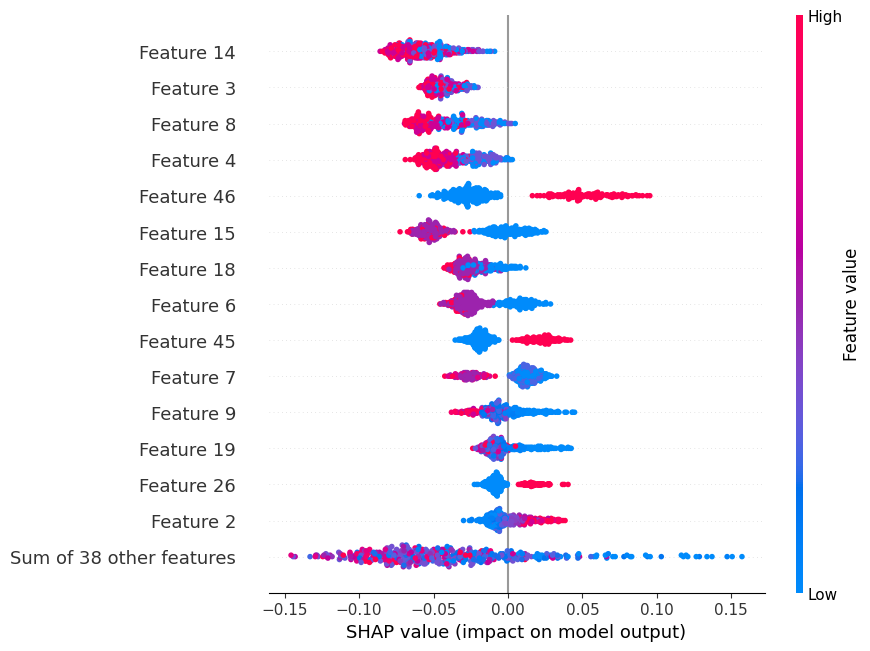

In [70]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Ensure test set matches training columns
X_test_rf = pd.DataFrame(X_test_Trees.values, columns=X_train_rf_sm.columns)

# Step 2: Convert training and test sets to clean NumPy float64 arrays
X_train_rf_sm_array = X_train_rf_sm.astype(float).to_numpy()
X_test_rf_array = X_test_rf.astype(float).to_numpy()

# Step 3: Create SHAP explainer with clean arrays
explainer = shap.Explainer(rf_model, X_train_rf_sm_array)

# Step 4: Compute SHAP values
shap_values = explainer(X_test_rf_array)
print("SHAP shape:", shap_values.values.shape)  # Expect (441, 49, 2)

# Step 5: Extract SHAP for Attrition = Yes (class 1)
shap_array_class1 = shap_values.values[:, :, 1]  # Shape: (441, 49)

# Step 6: Mean absolute SHAP values
mean_abs_shap = np.abs(shap_array_class1).mean(axis=0)

# Step 7: Top 15 summary with correct feature names
shap_summary_df = pd.DataFrame({
    'Feature': X_train_rf_sm.columns,  # Use original feature names
    'Mean_Abs_SHAP': mean_abs_shap
})

top_15_features = shap_summary_df.sort_values(by='Mean_Abs_SHAP', ascending=False).head(15)
print("🔍 Top 15 Features Influencing Attrition (Class 1):")
display(top_15_features)

# Step 8: Optional SHAP beeswarm
shap.plots.beeswarm(shap_values[:, :, 1], max_display=15)


# Logistic Regression

Cheking for Skewness

In [71]:
# Step 1: Select numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Step 2: Drop 'Attrition_binary' if it's in the list
numeric_cols = [col for col in numeric_cols if col != 'Attrition_binary']

# Optional: print to confirm
print(numeric_cols)


['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'TrainingTimesLastYear', 'YearsInCurrentRole', 'Compa Ratio', 'PromotionStagnation', 'RoleTenureRatio']


In [72]:
# Step 2: Calculate skewness
skew_values = df[numeric_cols].skew().sort_values(ascending=False)
# Step 3: Display as a DataFrame
skew_df = pd.DataFrame(skew_values, columns=['Skewness'])
display(skew_df)

,Skewness
MonthlyIncome,1.369817
PromotionStagnation,0.960110
DistanceFromHome,0.958118
YearsInCurrentRole,0.917363
PercentSalaryHike,0.821128
TrainingTimesLastYear,0.553124
Age,0.413286
Compa Ratio,0.233133
MonthlyRate,0.018578
DailyRate,-0.003519


In [73]:
# Step 4: Select columns with skewness > 0.6 or < -0.6
high_skew_cols = skew_df[(skew_df['Skewness'] > 0.6) | (skew_df['Skewness'] < -0.6)].index.tolist()

print("Columns with skewness > |0.6|:")
print(high_skew_cols)


Columns with skewness > |0.6|:
['MonthlyIncome', 'PromotionStagnation', 'DistanceFromHome', 'YearsInCurrentRole', 'PercentSalaryHike']


In [74]:
# Step 5: Apply log2(x + 1) transformation
for col in high_skew_cols:
    df[f'{col}_log2'] = np.log2(df[col] + 1)

In [75]:
# Step 6: Check skewness after transformation
log_cols = [f'{col}_log2' for col in high_skew_cols]
log_skew = df[log_cols].skew().sort_values(ascending=False)

print("\nSkewness after log2 transformation:")
print(log_skew)


Skewness after log2 transformation:
PromotionStagnation_log2    0.740597
PercentSalaryHike_log2      0.513543
MonthlyIncome_log2          0.286448
DistanceFromHome_log2      -0.029121
YearsInCurrentRole_log2    -0.383498
dtype: float64


Log Transformation done, still skewness exist. Applying cap and floor.

In [76]:
lower = df['PromotionStagnation_log2'].quantile(0.01)
upper = df['PromotionStagnation_log2'].quantile(0.99)
df['PromotionStagnation_log2'] = df['PromotionStagnation_log2'].clip(lower, upper)


In [77]:
# Step: Identify log-transformed columns
log2_cols = [
    'PromotionStagnation_log2',
    'PercentSalaryHike_log2',
    'MonthlyIncome_log2',
    'DistanceFromHome_log2',
    'YearsInCurrentRole_log2'
]

# Step: Calculate skewness
capped_skewness = df[log2_cols].skew().sort_values(ascending=False)

# Step: Display
capped_skew_df = pd.DataFrame(capped_skewness, columns=['Skewness_After_Capping'])
display(capped_skew_df)


,Skewness_After_Capping
PromotionStagnation_log2,0.740597
PercentSalaryHike_log2,0.513543
MonthlyIncome_log2,0.286448
DistanceFromHome_log2,-0.029121
YearsInCurrentRole_log2,-0.383498


Scale the Data (Before Logistic Regression)

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [79]:
X = df.drop(columns=['Attrition', 'Attrition_binary'], errors='ignore')
y = df['Attrition'].map({'Yes': 1, 'No': 0})


In [80]:
# Step 1: One-hot encode
X_encoded = pd.get_dummies(X, drop_first=True)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, stratify=y, random_state=1
)

# Step 3: Standardize
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


In [81]:
# Optional: Check shape and types
print("Scaled train shape:", X_train_scaled.shape)
print("Scaled test shape:", X_test_scaled.shape)

Scaled train shape: (1029, 61)
Scaled test shape: (441, 61)


Choosing the best Rebalancing technique

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline

# Container to store results
results = []

# Helper function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    return f1, auc

# SMOTE
smote = SMOTE(random_state=1)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

lr_smote = LogisticRegression(max_iter=1000, random_state=1)
lr_smote.fit(X_train_sm, y_train_sm)

f1, auc = evaluate_model(lr_smote, X_test_scaled, y_test)
results.append(("SMOTE", f1, auc))

# Random Oversampling
ros = RandomOverSampler(random_state=1)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)

lr_ros = LogisticRegression(max_iter=1000, random_state=1)
lr_ros.fit(X_train_ros, y_train_ros)

f1, auc = evaluate_model(lr_ros, X_test_scaled, y_test)
results.append(("Random Oversampling", f1, auc))

# Random Undersampling
rus = RandomUnderSampler(random_state=1)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

lr_rus = LogisticRegression(max_iter=1000, random_state=1)
lr_rus.fit(X_train_rus, y_train_rus)

f1, auc = evaluate_model(lr_rus, X_test_scaled, y_test)
results.append(("Random Undersampling", f1, auc))

# Class Weighting
lr_weighted = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=1)
lr_weighted.fit(X_train_scaled, y_train)

f1, auc = evaluate_model(lr_weighted, X_test_scaled, y_test)
results.append(("Class Weight (balanced)", f1, auc))

# Display all results
results_df = pd.DataFrame(results, columns=["Technique", "F1 Score", "ROC AUC"]).sort_values(by="ROC AUC", ascending=False)
display(results_df)


,Technique,F1 Score,ROC AUC
3,Class Weight (balanced),0.520179,0.836239
1,Random Oversampling,0.520179,0.835554
0,SMOTE,0.519231,0.831785
2,Random Undersampling,0.412451,0.802322


Going by ROC, Class Weight (balanced) is the winner here

In [83]:
best_row = results_df.iloc[0]

In [84]:
roc_auc_scores[f"Logistic Regression ({best_row['Technique']})"] = round(best_row['ROC AUC'], 4)
f1_scores[f"Logistic Regression ({best_row['Technique']})"] = round(best_row['F1 Score'], 4)


In [85]:
print(roc_auc_scores)
print(f1_scores)

{'Decision Tree': np.float64(0.6164), 'Decision Tree (Tuned + SMOTE + AUC)': np.float64(0.7427), 'Random Forest (SMOTE)': np.float64(0.8283), 'XGBoost (Tuned + SMOTE)': np.float64(0.8115), 'Logistic Regression (Class Weight (balanced))': np.float64(0.8362)}
{'Decision Tree': 0.3515, 'Decision Tree (Tuned + SMOTE + AUC)': 0.0, 'Random Forest (SMOTE)': 0.4086, 'XGBoost (Tuned + SMOTE)': 0.4959, 'Logistic Regression (Class Weight (balanced))': np.float64(0.5202)}


Model based on Class Weight (balanced)

In [86]:
from sklearn.linear_model import LogisticRegression

# Final Logistic Regression model with class weighting
final_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=1)
final_lr.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1)

## SHAP

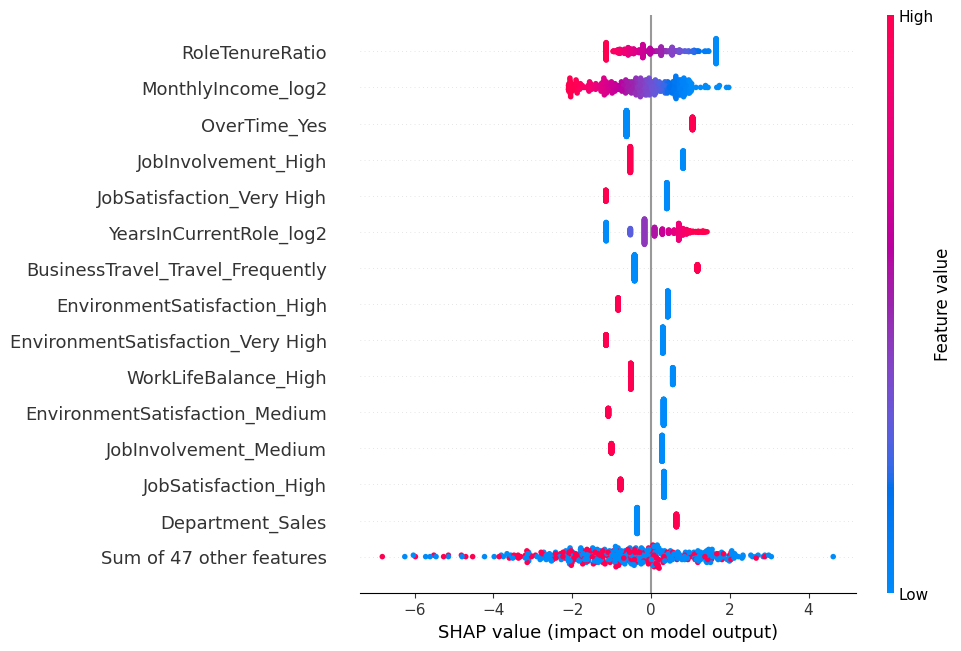

In [87]:
import shap

# Use the LinearExplainer for logistic regression
explainer = shap.Explainer(final_lr, X_train_ros, feature_names=X_train_ros.columns)
shap_values = explainer(X_test_scaled)

# Plot summary for class 1 (Attrition = Yes)
shap.plots.beeswarm(shap_values, max_display=15)

In [88]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

shap_summary_df = pd.DataFrame({
    'Feature': X_test_scaled.columns,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values(by='Mean_Abs_SHAP', ascending=False)

display(shap_summary_df.head(15))


,Feature,Mean_Abs_SHAP
11,RoleTenureRatio,0.777863
12,MonthlyIncome_log2,0.763516
49,OverTime_Yes,0.761938
30,JobInvolvement_High,0.641516
46,JobSatisfaction_Very High,0.622433
15,YearsInCurrentRole_log2,0.609279
17,BusinessTravel_Travel_Frequently,0.565734
27,EnvironmentSatisfaction_High,0.556858
28,EnvironmentSatisfaction_Very High,0.545460
54,WorkLifeBalance_High,0.528066


Club with Coefficients

In [89]:
# Step 1: Get mean absolute SHAP values
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

shap_df = pd.DataFrame({
    'Feature': X_test_scaled.columns,
    'Mean_Abs_SHAP': mean_abs_shap
})

# Step 2: Get logistic regression coefficients
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': final_lr.coef_[0]
})

# Step 3: Calculate odds ratios
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])

# Step 4: Merge all
summary_df = shap_df.merge(coef_df, on='Feature')
summary_df = summary_df.sort_values(by='Mean_Abs_SHAP', ascending=False)

# Step 5: Display top 15 features
display(summary_df.head(15))

,Feature,Mean_Abs_SHAP,Coefficient,Odds_Ratio
11,RoleTenureRatio,0.777863,-0.924123,0.396879
12,MonthlyIncome_log2,0.763516,-0.898602,0.407138
49,OverTime_Yes,0.761938,0.738623,2.093052
30,JobInvolvement_High,0.641516,-0.660397,0.516646
46,JobSatisfaction_Very High,0.622433,-0.720470,0.486524
15,YearsInCurrentRole_log2,0.609279,0.695007,2.003723
17,BusinessTravel_Travel_Frequently,0.565734,0.618872,1.856833
27,EnvironmentSatisfaction_High,0.556858,-0.578677,0.560639
28,EnvironmentSatisfaction_Very High,0.545460,-0.666205,0.513654
54,WorkLifeBalance_High,0.528066,-0.519902,0.594579


Mean SHAP value → how much the feature contributes to predictions

Coefficient → direction of influence (positive = increases attrition risk)

Odds Ratio → how much the risk changes (relative to baseline)



Stepwise logistic regression based on AIC

In [91]:
import statsmodels.api as sm

# 🔹 Step 1: Clean X_train and X_test to ensure all numeric
X_train_clean = X_train.apply(pd.to_numeric, errors='coerce')
X_test_clean = X_test.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN caused by coercion (optional)
X_train_clean = X_train_clean.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

# Align test set
X_test_clean = X_test_clean[X_train_clean.columns]

# 🔹 Step 2: Define the stepwise function with FI
def stepwise_logit_with_fi(X, y,
                            threshold_in=0.01,
                            threshold_out=0.05,
                            verbose=True):
    included = []
    while True:
        changed = False

        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pvals = pd.Series(index=excluded, dtype=float)
        for new_col in excluded:
            try:
                model = sm.Logit(y, sm.add_constant(X[included + [new_col]])).fit(disp=0)
                if new_col in model.pvalues:
                    new_pvals[new_col] = model.pvalues[new_col]
            except:
                continue

        if not new_pvals.empty:
            best_pval = new_pvals.min()
            if best_pval < threshold_in:
                best_feature = new_pvals.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add  {best_feature:30} | p-value {best_pval:.4f}")

        # Backward step
        try:
            model = sm.Logit(y, sm.add_constant(X[included])).fit(disp=0)
            pvals = model.pvalues.iloc[1:]  # exclude intercept
            worst_pval = pvals.max()
            if worst_pval > threshold_out:
                worst_feature = pvals.idxmax()
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print(f"Drop {worst_feature:30} | p-value {worst_pval:.4f}")
        except:
            break

        if not changed:
            break

    # Final model
    final_model = sm.Logit(y, sm.add_constant(X[included])).fit(disp=0)

    # Feature importance: standardized coefficients
    X_std = (X[included] - X[included].mean()) / X[included].std()
    std_model = sm.Logit(y, sm.add_constant(X_std)).fit(disp=0)
    coefs = std_model.params[1:]  # exclude intercept

    fi_df = pd.DataFrame({
        'Feature': coefs.index,
        'Standardized_Coefficient': coefs.values,
        'Abs_Importance': coefs.abs().values
    }).sort_values(by='Abs_Importance', ascending=False)

    return included, final_model, fi_df

# 🔹 Step 3: Run stepwise model
selected_features, final_model, fi_df = stepwise_logit_with_fi(X_train_clean, y_train_clean)

# 🔹 Step 4: View feature importance
display(fi_df)

# 🔹 Step 5: Evaluate on test set
X_test_selected = sm.add_constant(X_test_clean[selected_features])
y_pred_prob = final_model.predict(X_test_selected)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
# Binary F1 Score (for class 1 = Attrition)
f1 = f1_score(y_test, y_pred)

print("F1 Score:", round(f1, 4))

Add  MonthlyIncome_log2             | p-value 0.0000
Add  YearsInCurrentRole_log2        | p-value 0.0002
Add  DistanceFromHome_log2          | p-value 0.0033
Add  TrainingTimesLastYear          | p-value 0.0092


,Feature,Standardized_Coefficient,Abs_Importance
0,MonthlyIncome_log2,-0.455600,0.455600
1,YearsInCurrentRole_log2,-0.367083,0.367083
2,DistanceFromHome_log2,0.255684,0.255684
3,TrainingTimesLastYear,-0.236693,0.236693


              precision    recall  f1-score   support

           0       0.84      0.99      0.91       370
           1       0.50      0.03      0.05        71

    accuracy                           0.84       441
   macro avg       0.67      0.51      0.48       441
weighted avg       0.79      0.84      0.77       441

ROC AUC Score: 0.6866387514274838
F1 Score: 0.0533


In [92]:
# Calculate AUC and F1 for Stepwise model
auc_stepwise = roc_auc_score(y_test, y_pred_prob)
f1_stepwise = f1_score(y_test, y_pred)

# Store in result containers
roc_auc_scores['Logistic Regression (Stepwise AIC)'] = round(auc_stepwise, 4)
f1_scores['Logistic Regression (Stepwise AIC)'] = round(f1_stepwise, 4)


Don’t use the stepwise model as final predictive model — it sacrifices recall and F1 score, making it practically unusable for HR decision-making.

# Neural Network

In [93]:
def build_and_train_nn(X_train, y_train, X_test, y_test, class_weights=None, verbose=0):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import roc_auc_score, f1_score

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=verbose,
        class_weight=class_weights
    )

    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    return f1, auc


In [94]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

nn_results = []

# 1. SMOTE
X_smote, y_smote = SMOTE(random_state=1).fit_resample(X_train_scaled, y_train)
f1, auc = build_and_train_nn(X_smote, y_smote, X_test_scaled, y_test)
nn_results.append(("SMOTE", f1, auc))

# 2. Random Oversampling
X_ros, y_ros = RandomOverSampler(random_state=1).fit_resample(X_train_scaled, y_train)
f1, auc = build_and_train_nn(X_ros, y_ros, X_test_scaled, y_test)
nn_results.append(("Random Oversampling", f1, auc))

# 3. Random Undersampling
X_rus, y_rus = RandomUnderSampler(random_state=1).fit_resample(X_train_scaled, y_train)
f1, auc = build_and_train_nn(X_rus, y_rus, X_test_scaled, y_test)
nn_results.append(("Random Undersampling", f1, auc))

# 4. Class Weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
cw_dict = {0: class_weights[0], 1: class_weights[1]}
f1, auc = build_and_train_nn(X_train_scaled, y_train, X_test_scaled, y_test, class_weights=cw_dict)
nn_results.append(("Class Weight (balanced)", f1, auc))

# Show results
nn_results_df = pd.DataFrame(nn_results, columns=["Technique", "F1 Score", "ROC AUC"]).sort_values(by="ROC AUC", ascending=False)
display(nn_results_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,Technique,F1 Score,ROC AUC
3,Class Weight (balanced),0.563536,0.838523
0,SMOTE,0.567376,0.807080
1,Random Oversampling,0.500000,0.796650
2,Random Undersampling,0.448087,0.713399


Class Weight (balanced) is the best rebalancing technique

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Recompute class weights (again, use np.array)
import numpy as np
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
cw_dict = {0: class_weights[0], 1: class_weights[1]}

# Build refined model
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=cw_dict,
    verbose=1
)

# Predict and evaluate
y_pred_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score, f1_score

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", round(roc_auc_score(y_test, y_pred_prob), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - AUC: 0.5452 - loss: 0.8070 - val_AUC: 0.6557 - val_loss: 0.5856
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.6674 - loss: 0.6689 - val_AUC: 0.7157 - val_loss: 0.5806
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7655 - loss: 0.5996 - val_AUC: 0.7560 - val_loss: 0.5678
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7778 - loss: 0.5960 - val_AUC: 0.7697 - val_loss: 0.5507
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7771 - loss: 0.5665 - val_AUC: 0.7765 - val_loss: 0.5313
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8225 - loss: 0.5353 - val_AUC: 0.7879 - val_loss: 0.5235
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8638 - loss: 0.4727 - val_AUC: 0.7907 - val_loss: 0.4993
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8571 - loss: 0.4645 - val_AUC: 0.7938 - val_loss: 0.4991
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.887

In [96]:
# Calculate AUC and F1
auc_nn = roc_auc_score(y_test, y_pred_prob)
f1_nn = f1_score(y_test, y_pred)

# Store results in containers
roc_auc_scores['Neural Network (Class Weight)'] = round(auc_nn, 4)
f1_scores['Neural Network (Class Weight)'] = round(f1_nn, 4)

Hyperparameter Tuning


In [97]:
!pip install -q -U keras-tuner  # if not installed

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    # Tune number of layers (2 to 4)
    for i in range(hp.Int("num_layers", 2, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=32),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.4, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    # Learning rate
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['AUC'])
    return model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [98]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_AUC", direction="max"),
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="nn_tuning_v2",
    project_name="refined_nn"
)


In [99]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

tuner.search(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,  # You can tune this too, if needed
    callbacks=[early_stop],
    class_weight=cw_dict,  # ✅ Important
    verbose=1
)


Trial 10 Complete [00h 00m 25s]
val_AUC: 0.8314102292060852

Best val_AUC So Far: 0.8736110329627991
Total elapsed time: 00h 04m 27s


In [100]:
best_model = tuner.get_best_models(num_models=1)[0]

# Predict and evaluate
y_pred_prob = best_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

from sklearn.metrics import roc_auc_score, f1_score, classification_report

print("Tuned NN (Class Weights)")
print("ROC AUC:", round(roc_auc_score(y_test, y_pred_prob), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Tuned NN (Class Weights)
ROC AUC: 0.809
F1 Score: 0.5098


In [101]:
roc_auc_scores["Neural Network (Tuned + Class Weights)"] = round(roc_auc_score(y_test, y_pred_prob), 4)

# Optional: display full sorted table
auc_df = pd.DataFrame.from_dict(roc_auc_scores, orient='index', columns=['AUC']).reset_index()
auc_df = auc_df.rename(columns={'index': 'Model'}).sort_values(by='AUC', ascending=False)
display(auc_df)


,Model,AUC
4,Logistic Regression (Class Weight (balanced)),0.8362
2,Random Forest (SMOTE),0.8283
3,XGBoost (Tuned + SMOTE),0.8115
7,Neural Network (Tuned + Class Weights),0.8090
6,Neural Network (Class Weight),0.7703
1,Decision Tree (Tuned + SMOTE + AUC),0.7427
5,Logistic Regression (Stepwise AIC),0.6866
0,Decision Tree,0.6164


In [102]:
# Store F1 Score
f1_scores["Neural Network (Tuned + Class Weights)"] = round(f1_score(y_test, y_pred), 4)

# Optional: display full sorted F1 table
f1_df = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['F1 Score']).reset_index()
f1_df = f1_df.rename(columns={'index': 'Model'}).sort_values(by='F1 Score', ascending=False)
display(f1_df)


,Model,F1 Score
4,Logistic Regression (Class Weight (balanced)),0.5202
7,Neural Network (Tuned + Class Weights),0.5098
3,XGBoost (Tuned + SMOTE),0.4959
6,Neural Network (Class Weight),0.4607
2,Random Forest (SMOTE),0.4086
0,Decision Tree,0.3515
5,Logistic Regression (Stepwise AIC),0.0533
1,Decision Tree (Tuned + SMOTE + AUC),0.0000


Combined F1 + AUC Table

In [103]:
# Merge both dictionaries into one DataFrame
combined_df = pd.DataFrame({
    'F1 Score': f1_scores,
    'AUC': roc_auc_scores
}).reset_index().rename(columns={'index': 'Model'})

# Sort by F1 Score (or AUC if preferred)
combined_df = combined_df.sort_values(by='F1 Score', ascending=False)

# Display the combined performance table
display(combined_df)


,Model,F1 Score,AUC
4,Logistic Regression (Class Weight (balanced)),0.5202,0.8362
7,Neural Network (Tuned + Class Weights),0.5098,0.8090
3,XGBoost (Tuned + SMOTE),0.4959,0.8115
6,Neural Network (Class Weight),0.4607,0.7703
2,Random Forest (SMOTE),0.4086,0.8283
0,Decision Tree,0.3515,0.6164
5,Logistic Regression (Stepwise AIC),0.0533,0.6866
1,Decision Tree (Tuned + SMOTE + AUC),0.0000,0.7427


Based on the ROC AUC:
Prioritize Logistic Regression (ROS) and Random Forest (SMOTE) for final model selection and SHAP-based interpretation.

SHAP from NN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━

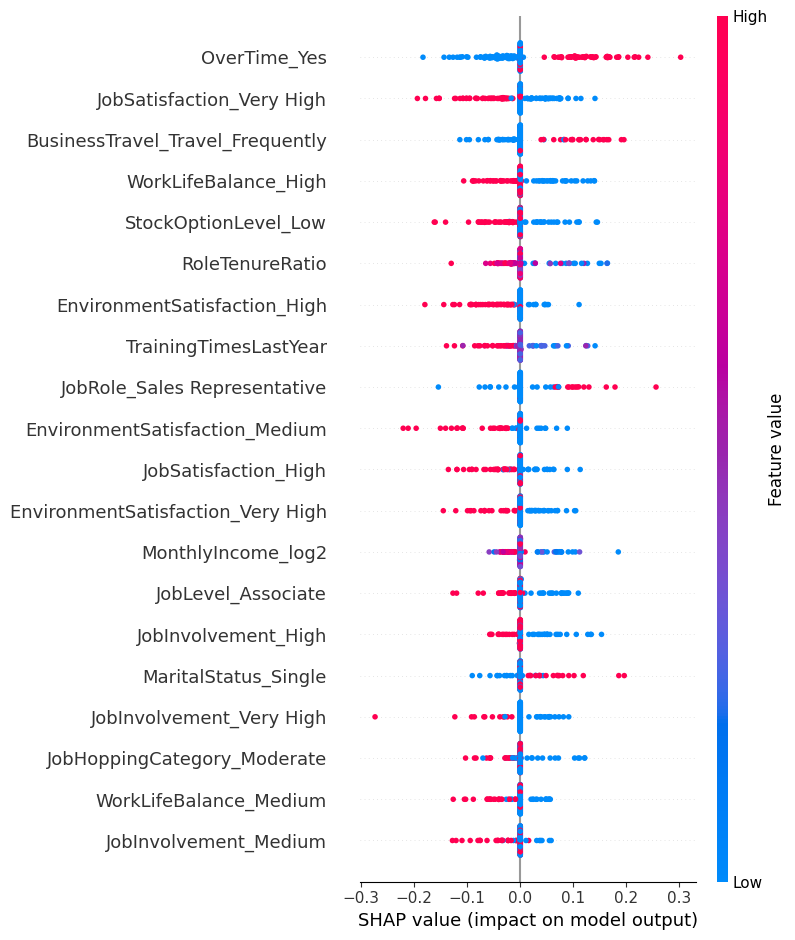

In [104]:
# 1. Sample background data (from train)
X_background = X_train_scaled.sample(100, random_state=1)

# 2. Sample from test for speed (optional: full test set if time allows)
X_sample = X_test_scaled.sample(200, random_state=1)

# 3. Define prediction function for SHAP
def nn_predict(X):
    return best_model.predict(X).ravel()

# 4. Create KernelExplainer
explainer = shap.KernelExplainer(nn_predict, X_background)

# 5. Compute SHAP values
shap_values = explainer.shap_values(X_sample, nsamples=100)

# 6. Summary Plot
shap.summary_plot(shap_values, X_sample, feature_names=X_sample.columns)

In [105]:
# Mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    'Feature': X_sample.columns,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values(by='Mean_Abs_SHAP', ascending=False)

display(shap_df.head(15))


,Feature,Mean_Abs_SHAP
49,OverTime_Yes,0.052909
46,JobSatisfaction_Very High,0.027525
17,BusinessTravel_Travel_Frequently,0.019791
54,WorkLifeBalance_High,0.017736
50,StockOptionLevel_Low,0.016855
11,RoleTenureRatio,0.016206
27,EnvironmentSatisfaction_High,0.015427
7,TrainingTimesLastYear,0.013985
43,JobRole_Sales Representative,0.013085
26,EnvironmentSatisfaction_Medium,0.013062
